In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
METABO_PATH = '/net/mraid20/export/genie/LabData/Analyses/davidkro/batch_normalizations'
DIET_PAPER_PATH = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper'
tomer_dir = '/net/mraid20/export/genie/LabData/Analyses/tomerse/david_colab/'
figs_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Figs_paper/'
import os.path as op
import scipy.stats as stats

In [460]:
ms_metadata = pd.read_csv(METABO_PATH + '/metadata_with_date.csv', index_col=0)
batch_info = pd.read_csv(METABO_PATH + '/batch_info/batches_order_info_1_38.csv', index_col=0)
serrf_all = pd.read_csv(DIET_PAPER_PATH + '/serrf_all.csv', index_col=0)
clustered_all = pd.read_csv(DIET_PAPER_PATH + '/clusterd_09_all.csv', index_col=0)
diet_features = pd.read_pickle(tomer_dir + 'diet_features_v2.pkl').drop(columns=['age'])
diet_features_v2 = pd.read_pickle(tomer_dir + 'diet_features_02_visit_v2.pkl').drop(columns=['age'])
diet_features_v2_02 = pd.read_pickle(tomer_dir + 'diet_features_02_visit_v2.pkl').drop(columns=['age'])
nova_scores_baseline = pd.read_csv('/net/mraid20/export/genie/LabData/Data/10K/foods/upf_baseline.csv')
nova_score_visit2 = pd.read_csv('/net/mraid20/export/genie/LabData/Data/10K/foods/upf_2y.csv')

In [574]:
diet_features_updated =  pd.read_pickle(tomer_dir + 'diet_features_v4.pkl').drop(columns=['age'])

In [9]:
# serrf_all = clustered_all

In [725]:
# import annotations
annotations = pd.read_csv(op.join(METABO_PATH,'Matched_Annotations', 'Full_Annotation_Table_36_1_5ppm_copy.csv'))

In [726]:
annotations = annotations.drop_duplicates()

In [727]:
# remove rows with Pos string in PLATFORM
# annotations = annotations[~annotations['PLATFORM'].str.contains('Pos', na=False)]

In [728]:
annotations.columns

Index(['Original_Compound', 'Original_mz', 'Retention_time', 'CCS',
       'Matched_Compound', 'Matched_Mass', 'Mass_Difference_ppm',
       'Super_Pathway', 'Sub_Pathway', 'PubChem', 'KEGG', 'HMDB', 'Source',
       'PLATFORM'],
      dtype='object')

In [729]:
diet_scores = [
    'IMEDAS_score_per_day',
    'eatLANCET_score_per_day',
    'aHEI_score_per_day',
    'DASH_score',
    'hPDI_score_per_day',
    'vegetarian_score_per_day',
    'vegan_score_per_day',
    'carnivore_score_per_day',
    'low_carb_diet',
    'pct_NOVA_4',
]

In [730]:
ms_baseline = serrf_all[serrf_all['research_stage'] == 'baseline'].copy()
ms_2y = serrf_all[serrf_all['research_stage'] == '02_00_visit'].copy()

In [731]:
serrf_all_t = serrf_all.T

In [732]:
serrf_all_t['Original_Compound'] = serrf_all_t.index.str.split('_').str[:-1].str.join('_')

In [733]:
def match_metabolite_columns(metabolite_df, annotations_df):
    """
    Match metabolite column names with annotations from the reference table
    by directly matching column names (with CCS suffix removed) to the Original_Compound column.
    For duplicate matched metabolites, keeps only the column with the highest median value.
    
    Parameters:
    -----------
    metabolite_df : pandas.DataFrame
        The original metabolite table with columns to be matched
    annotations_df : pandas.DataFrame
        The annotations table with reference information
    
    Returns:
    --------
    pandas.DataFrame
        A new dataframe with matched column names
    dict
        Mapping between original column names and new column names
    """
    # Create a dictionary to store column name mappings
    column_mapping = {}
    
    # Create a lookup dictionary from annotations dataframe
    # Using Original_Compound as key and Matched_Compound as value
    annotation_lookup = {}
    
    for _, row in annotations_df.iterrows():
        original = str(row['Original_Compound'])
        matched = str(row['Matched_Compound'])
        mass_diff = row['Mass_Difference_ppm']
        
        # First, ensure the matched compound is a valid candidate
        if 'X -' not in matched:
            # If we already have this compound in our lookup, check if the new one is better
            if original in annotation_lookup:
                existing_entry = annotation_lookup[original]
                existing_diff = existing_entry['mass_diff']
                
                # Only replace if the new one has a smaller absolute mass difference
                if abs(mass_diff) < abs(existing_diff):
                    # Print the details of the substitution before it happens
                    print(f"? Substitution for '{original}':")
                    print(f"   - Replacing '{existing_entry['matched']}' (Mass Diff: {existing_diff:.4f} ppm)")
                    print(f"   - With '{matched}' (Mass Diff: {mass_diff:.4f} ppm)\n")
                    
                    # Perform the substitution
                    annotation_lookup[original] = {'matched': matched, 'mass_diff': mass_diff}
                    
            # If the compound isn't in our lookup yet, add it as a new entry
            else:
                annotation_lookup[original] = {'matched': matched, 'mass_diff': mass_diff}
    
    # First pass: identify all metabolite columns and their matched names
    metabolite_columns = {}  # Will store {original_col: matched_name}
    non_metabolite_columns = {}  # Will store {original_col: original_col}
        
    for col in metabolite_df.columns:
        # Check if this is a metabolite column (contains m/z or contains n)
        if 'm/z' in col or 'n_' in col:
            # Remove CCS suffix to get the matching name
            if 'm/z' in col:
                # Format: 3.99_357.1006m/z_178.03
                column_base = col.split('m/z_')[0] + 'm/z'
            elif 'n_' in col:
                # Format: 3.87_520.3238n_223.82
                column_base = col.split('n_')[0] + 'n'
            
            # Look for a direct match in the annotation lookup
            if column_base in annotation_lookup:
                # Found a match
                matched_name = annotation_lookup[column_base]['matched']
                metabolite_columns[col] = matched_name
            # No else needed - we'll skip columns with no match
        else:
            # Non-metabolite column, keep as is
            non_metabolite_columns[col] = col
    
    # Second pass: handle duplicate matched metabolites by keeping the one with highest median
    # Group by matched name
    duplicates = {}  # Will store {matched_name: [original_col1, original_col2, ...]}
    
    for col, matched_name in metabolite_columns.items():
        if matched_name not in duplicates:
            duplicates[matched_name] = []
        duplicates[matched_name].append(col)
    
    # For each matched name with multiple original columns, keep only the one with highest median
    final_metabolite_columns = {}  # Will store {original_col: matched_name} for kept columns
    
    for matched_name, original_cols in duplicates.items():
        if len(original_cols) == 1:
            # No duplicates for this matched name
            final_metabolite_columns[original_cols[0]] = matched_name
        else:
            # Calculate median for each column
            medians = {col: metabolite_df[col].median() for col in original_cols}
            # Find the column with the highest median
            best_col = max(original_cols, key=lambda col: medians[col])
            # Keep only this column
            final_metabolite_columns[best_col] = matched_name
    
    # Combine metabolite and non-metabolite columns
    column_mapping = {**final_metabolite_columns, **non_metabolite_columns}
    
    # Create the new dataframe with only the selected columns
    columns_to_keep = list(column_mapping.keys())
    new_df = metabolite_df[columns_to_keep].copy()
    new_df.columns = [column_mapping[col] for col in columns_to_keep]
    
    return new_df, column_mapping

In [734]:
matched_df, column_mapping = match_metabolite_columns(serrf_all, annotations)

? Substitution for '4.01_257.1764m/z':
   - Replacing 'tetradecanedioate' (Mass Diff: -1.9955 ppm)
   - With 'branched chain 14:0 dicarboxylic acid**' (Mass Diff: -0.9457 ppm)

? Substitution for '4.08_257.1762m/z':
   - Replacing 'tetradecanedioate' (Mass Diff: -1.9753 ppm)
   - With 'branched chain 14:0 dicarboxylic acid**' (Mass Diff: -0.9254 ppm)

? Substitution for '0.61_168.0778m/z':
   - Replacing '3-methylhistidine' (Mass Diff: 1.3113 ppm)
   - With '1-methylhistidine' (Mass Diff: 1.0019 ppm)

? Substitution for '1.30_218.9969m/z':
   - Replacing '3-methoxycatechol sulfate (2)' (Mass Diff: -1.5411 ppm)
   - With '2-methoxyresorcinol sulfate' (Mass Diff: -1.4498 ppm)

? Substitution for '1.32_165.0420m/z':
   - Replacing '1-methylxanthine' (Mass Diff: -1.1470 ppm)
   - With '7-methylxanthine' (Mass Diff: -0.8561 ppm)

? Substitution for '1.54_195.0527m/z':
   - Replacing '3,7-dimethylurate' (Mass Diff: -1.6206 ppm)
   - With '1,3-dimethylurate' (Mass Diff: -1.4155 ppm)

? Substi

In [735]:
# save the column mapping for future reference
mapping_df = pd.DataFrame(column_mapping.items(), columns=['Original_Column', 'Matched_Column'])
mapping_df.to_csv(op.join(METABO_PATH, 'Matched_Annotations', 'column_mapping_batch36_1.csv'), index=False)

In [736]:
def analyze_metabolite_pathways(metabolite_df, annotations_df, sample_metadata=None):
    """
    Analyze and quantify metabolites grouped by Super Pathway from untargeted LC-MS data.
    
    Parameters:
    -----------
    metabolite_df : pandas.DataFrame
        Dataframe containing metabolite peak areas with matched compound names as columns
    annotations_df : pandas.DataFrame
        Dataframe containing annotations with Super_Pathway information
    sample_metadata : pandas.DataFrame, optional
        Dataframe containing sample metadata (e.g., groups, conditions, etc.)
    
    Returns:
    --------
    dict
        Dictionary containing various analysis results
    """
    results = {}
    
    # 1. Create a mapping from metabolite name to Super Pathway
    pathway_mapping = {}
    for _, row in annotations_df.iterrows():
        pathway_mapping[row['Matched_Compound']] = row['Super_Pathway']
    
    # 2. Identify which columns are metabolites (those found in our mapping)
    metabolite_columns = [col for col in metabolite_df.columns if col in pathway_mapping]
    non_metabolite_columns = [col for col in metabolite_df.columns if col not in pathway_mapping]
    
    # 3. Apply log transformation to handle the skewed nature of peak areas
    # Note: Adding a small value to avoid log(0) issues
    log_df = metabolite_df.copy()
    
    # Find the minimum non-zero value across all metabolite columns
    min_value = metabolite_df[metabolite_columns].replace(0, np.nan).min().min()
    
    # Replace zeros with NaN, then fill NaNs with a small value, then apply log
    for col in metabolite_columns:
        # Replace zeros with a small fraction of the minimum value
        log_df[col] = log_df[col].replace(0, np.nan).fillna(min_value * 0.1)
        # Apply log transformation
        log_df[col] = np.log(log_df[col])
    
    # 4. Group metabolites by Super Pathway
    pathway_groups = {}
    for pathway in annotations_df['Super_Pathway'].unique():
        if pd.isna(pathway):
            continue
        pathway_metabolites = [m for m in metabolite_columns if pathway_mapping.get(m) == pathway]
        if pathway_metabolites:
            pathway_groups[pathway] = pathway_metabolites
    
    results['pathway_groups'] = pathway_groups
    
    # 5. Calculate summed and mean pathway intensities
    # Note: We sum the raw values, not the log-transformed ones
    pathway_sums = pd.DataFrame(index=metabolite_df.index)
    pathway_means = pd.DataFrame(index=metabolite_df.index)
    pathway_medians = pd.DataFrame(index=metabolite_df.index)
    
    for pathway, compounds in pathway_groups.items():
        # Sum of intensities for each pathway
        pathway_sums[f"{pathway}_sum"] = metabolite_df[compounds].sum(axis=1)
        
        # Mean intensity for each pathway (on raw values)
        pathway_means[f"{pathway}_mean"] = metabolite_df[compounds].mean(axis=1)
        
        # Median intensity for each pathway (on raw values)
        pathway_medians[f"{pathway}_median"] = metabolite_df[compounds].median(axis=1)
    
    results['pathway_sums'] = pathway_sums
    results['pathway_means'] = pathway_means
    results['pathway_medians'] = pathway_medians
    
    # 6. Normalize pathway sums using methods appropriate for metabolomics
    # Method 1: Total Sum Normalization (relative abundance)
    total_intensity = pathway_sums.sum(axis=1)
    pathway_sums_norm = pathway_sums.div(total_intensity, axis=0) * 100  # as percentages
    results['pathway_sums_normalized'] = pathway_sums_norm
    
    # 7. Calculate pathway representation metrics
    pathway_coverage = {pathway: len(compounds) for pathway, compounds in pathway_groups.items()}
    results['pathway_coverage'] = pathway_coverage
    
    # 8. Statistical comparison between groups (if sample metadata provided)
    if sample_metadata is not None and 'Group' in sample_metadata.columns:
        # Merge sample metadata
        merged_data = pd.merge(
            pathway_sums_norm, 
            sample_metadata,
            left_index=True, 
            right_index=True
        )
        
        # Statistical tests between groups
        stats_results = {}
        groups = merged_data['Group'].unique()
        
        if len(groups) == 2:  # Two-group comparison (e.g., t-test)
            for pathway in pathway_sums_norm.columns:
                group1_data = merged_data[merged_data['Group'] == groups[0]][pathway]
                group2_data = merged_data[merged_data['Group'] == groups[1]][pathway]
                
                # Shapiro-Wilk test for normality
                _, p_norm1 = stats.shapiro(group1_data)
                _, p_norm2 = stats.shapiro(group2_data)
                
                if p_norm1 > 0.05 and p_norm2 > 0.05:  # Data is normal
                    # t-test for normal data
                    _, p_value = stats.ttest_ind(group1_data, group2_data)
                    test_used = "t-test"
                else:  # Data is not normal
                    # Mann-Whitney U test for non-normal data
                    _, p_value = stats.mannwhitneyu(group1_data, group2_data)
                    test_used = "Mann-Whitney U"
                
                stats_results[pathway] = {
                    'p_value': p_value,
                    'test': test_used,
                    'significant': p_value < 0.05
                }
        
        results['statistical_tests'] = stats_results
    
    # 9. Visualizations
    # Create a pathway proportion plot (as percentage of total)
    pathway_props = pathway_sums_norm.mean().sort_values(ascending=False)
    pathway_props_df = pd.DataFrame({'Pathway': pathway_props.index, 'Proportion (%)': pathway_props.values})
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=pathway_props_df, x='Proportion (%)', y='Pathway')
    plt.title('Average Proportion of Metabolite Super Pathways')
    plt.tight_layout()
    
    # Save the plot and store in results
    results['pathway_proportion_plot'] = plt.gcf()
    
    return results


def calculate_pathway_fold_changes(metabolite_df, annotations_df, group_column, group1, group2):
    """
    Calculate fold changes between two groups for metabolite super pathways.
    
    Parameters:
    -----------
    metabolite_df : pandas.DataFrame
        DataFrame containing metabolite peak areas and group information
    annotations_df : pandas.DataFrame
        DataFrame with metabolite annotations including Super_Pathway information
    group_column : str
        Column name in metabolite_df that contains group information
    group1 : str
        Name of the first group
    group2 : str
        Name of the second group
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing fold changes and significance for each pathway
    """
    # Create pathway mapping
    pathway_mapping = {}
    for _, row in annotations_df.iterrows():
        pathway_mapping[row['Matched_Compound']] = row['Super_Pathway']
    
    # Identify metabolite columns
    metabolite_columns = [col for col in metabolite_df.columns if col in pathway_mapping]
    
    # Group metabolites by pathway
    pathway_groups = {}
    for pathway in annotations_df['Super_Pathway'].unique():
        if pd.isna(pathway):
            continue
        pathway_metabolites = [m for m in metabolite_columns if pathway_mapping.get(m) == pathway]
        if pathway_metabolites:
            pathway_groups[pathway] = pathway_metabolites
    
    # Calculate pathway sums
    pathway_sums = pd.DataFrame(index=metabolite_df.index)
    for pathway, compounds in pathway_groups.items():
        pathway_sums[pathway] = metabolite_df[compounds].sum(axis=1)
    
    # Merge with group information
    merged_data = pd.merge(
        pathway_sums,
        metabolite_df[[group_column]],
        left_index=True,
        right_index=True
    )
    
    # Calculate fold changes and p-values
    results = []
    
    for pathway in pathway_groups.keys():
        # Get values for each group
        group1_values = merged_data[merged_data[group_column] == group1][pathway]
        group2_values = merged_data[merged_data[group_column] == group2][pathway]
        
        # Calculate means
        mean1 = group1_values.mean()
        mean2 = group2_values.mean()
        
        # Calculate fold change
        if mean1 > 0 and mean2 > 0:
            fold_change = mean2 / mean1
            log2_fold_change = np.log2(fold_change)
        else:
            fold_change = np.nan
            log2_fold_change = np.nan
        
        # Perform statistical test
        # Check for normality
        _, p_norm1 = stats.shapiro(group1_values) if len(group1_values) >= 3 else (0, 0)
        _, p_norm2 = stats.shapiro(group2_values) if len(group2_values) >= 3 else (0, 0)
        
        if p_norm1 > 0.05 and p_norm2 > 0.05:
            # Use t-test for normal data
            _, p_value = stats.ttest_ind(group1_values, group2_values)
            test_used = "t-test"
        else:
            # Use Mann-Whitney for non-normal data
            _, p_value = stats.mannwhitneyu(group1_values, group2_values)
            test_used = "Mann-Whitney U"
        
        # Store results
        results.append({
            'Pathway': pathway,
            'Mean_' + group1: mean1,
            'Mean_' + group2: mean2,
            'Fold_Change': fold_change,
            'Log2_Fold_Change': log2_fold_change,
            'P_Value': p_value,
            'Test_Used': test_used,
            'Significant': p_value < 0.05,
            'Metabolites_Count': len(pathway_groups[pathway])
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('P_Value')
    
    return results_df

In [737]:
def analyze_metabolites_by_diet_adherence(
    metabolites_df, 
    diet_features, 
    diet_features_v2,
    annotations_df,
    diet_score_column, 
    percentile_threshold=75,
    n_pathways=10,
    debug=True
):
    """
    Analyze changes in metabolite superpathways for subjects with high adherence to a specific diet score.
    Works with a single metabolites dataframe that contains RegistrationCode and research_stage columns.
    Uses Seaborn for visualization and excludes Unknown pathways.
    
    Parameters:
    -----------
    metabolites_df : pandas.DataFrame
        DataFrame containing metabolite measurements with RegistrationCode, research_stage, and metabolite data
    diet_features : pandas.DataFrame
        DataFrame containing baseline diet adherence scores with RegistrationCode as index
    diet_features_v2 : pandas.DataFrame
        DataFrame containing 2-year followup diet adherence scores with RegistrationCode as index
    annotations_df : pandas.DataFrame
        DataFrame containing metabolite annotations with Matched_Compound and Super_Pathway columns
    diet_score_column : str
        Name of the column containing the diet adherence score to analyze
    percentile_threshold : float, default=75
        Percentile threshold to define "top adherent" individuals (e.g., 75 for top 25%)
    n_pathways : int, default=10
        Number of top pathways to include in the visualization
        
    Returns:
    --------
    dict
        Dictionary containing analysis results and plots
    """
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    results = {}
    
    # 1. Prepare the diet adherence data
    # Make sure indices are of the same type
    baseline_diet_df = diet_features.copy()
    followup_diet_df = diet_features_v2.copy()
    
    baseline_diet_df.index = baseline_diet_df.index.astype(str)
    followup_diet_df.index = followup_diet_df.index.astype(str)
    
    # Rename columns to indicate timepoints
    baseline_cols = {col: f"Baseline_{col}" for col in baseline_diet_df.columns}
    followup_cols = {col: f"Followup_{col}" for col in followup_diet_df.columns}
    
    baseline_diet_df = baseline_diet_df.rename(columns=baseline_cols)
    followup_diet_df = followup_diet_df.rename(columns=followup_cols)
    
    # Merge baseline and followup data
    diet_df = pd.merge(
        baseline_diet_df, 
        followup_diet_df,
        left_index=True,
        right_index=True,
        how='inner',
        suffixes=('_base', '_follow')
    )
    
    # Calculate adherence change
    baseline_score_col = f"Baseline_{diet_score_column}"
    followup_score_col = f"Followup_{diet_score_column}"
    
    diet_df['Adherence_Change'] = diet_df[followup_score_col] - diet_df[baseline_score_col]
    
    # 2. Identify top adherent individuals
    # Calculate the threshold for top adherent subjects
    baseline_threshold = np.percentile(diet_df[baseline_score_col].dropna(), percentile_threshold)
    followup_threshold = np.percentile(diet_df[followup_score_col].dropna(), percentile_threshold)
    
    if debug:
        print(f"Baseline threshold ({percentile_threshold}th percentile): {baseline_threshold}")
        print(f"Followup threshold ({percentile_threshold}th percentile): {followup_threshold}")
    
    # Identify subjects who are top adherent at either timepoint
    # Using index which is the RegistrationCode
    top_adherent_baseline = diet_df[diet_df[baseline_score_col] >= baseline_threshold].index.tolist()
    top_adherent_followup = diet_df[diet_df[followup_score_col] >= followup_threshold].index.tolist()
    
    # Get subjects who are top adherent at both timepoints
    consistently_adherent = list(set(top_adherent_baseline) & set(top_adherent_followup))
    
    # Get subjects who became adherent (not adherent at baseline, but adherent at followup)
    became_adherent = list(set(top_adherent_followup) - set(top_adherent_baseline))
    
    # Get subjects who lost adherence (adherent at baseline, but not at followup)
    lost_adherence = list(set(top_adherent_baseline) - set(top_adherent_followup))
    
    if debug:
        print(f"Found {len(consistently_adherent)} consistently adherent subjects")
        print(f"Found {len(became_adherent)} subjects who became adherent")
        print(f"Found {len(lost_adherence)} subjects who lost adherence")
    
    # 3. Identify complete subjects with both baseline and followup data
    # Get unique subjects in the metabolites dataframe
    subject_stages = metabolites_df.groupby('RegistrationCode')['research_stage'].unique().to_dict()
    
    # Find subjects with both baseline and followup data
    complete_subjects = [
        subject for subject, stages in subject_stages.items()
        if 'baseline' in stages and '02_00_visit' in stages
    ]
    
    if debug:
        print(f"Found {len(complete_subjects)} subjects with both baseline and 2y data")
    
    # Filter for top adherent subjects who have complete data
    top_adherent_complete = [
        subject for subject in complete_subjects
        if (subject in top_adherent_baseline or subject in top_adherent_followup)
    ]
    
    if debug:
        print(f"Found {len(top_adherent_complete)} top adherent subjects with complete data")
    
    # 4. Create pathway mapping from annotations table
    def get_pathway_mapping(annotations_df):
        """Create a mapping from metabolite name to its superpathway"""
        pathway_mapping = {}
        for _, row in annotations_df.iterrows():
            pathway_mapping[row['Matched_Compound']] = row['Super_Pathway']
        return pathway_mapping
    
    # Get unique superpathways from annotations, excluding Unknowns
    all_pathways = [p for p in annotations_df['Super_Pathway'].dropna().unique().tolist() if p != "Unknowns"]
    
    # Create metabolite to pathway mapping
    pathway_mapping = get_pathway_mapping(annotations_df)
    
    if debug:
        print(f"Found {len(all_pathways)} unique metabolite pathways (excluding Unknowns)")
        print(f"Created pathway mapping for {len(pathway_mapping)} metabolites")
    
    # 5. Separate metabolite data by timepoint for top adherent subjects
    # Get metabolite columns (exclude metadata columns)
    metadata_cols = ['RegistrationCode', 'research_stage']
    metabolite_cols = [col for col in metabolites_df.columns if col not in metadata_cols]
    
    # Filter for baseline data
    baseline_data = metabolites_df[
        (metabolites_df['RegistrationCode'].isin(top_adherent_complete)) & 
        (metabolites_df['research_stage'] == 'baseline')
    ]
    
    # Filter for followup data
    followup_data = metabolites_df[
        (metabolites_df['RegistrationCode'].isin(top_adherent_complete)) & 
        (metabolites_df['research_stage'] == '02_00_visit')
    ]
    
    # 6. Calculate pathway proportions for each subject at each timepoint
    baseline_pathway_props = calculate_pathway_proportions(baseline_data, all_pathways, metabolite_cols, pathway_mapping)
    followup_pathway_props = calculate_pathway_proportions(followup_data, all_pathways, metabolite_cols, pathway_mapping)
    
    # Add adherence groups - showing all subjects in both timepoints for visualization
    # For baseline data, track all adherence groups including those who will become adherent
    baseline_pathway_props['Adherence_Group'] = baseline_pathway_props['RegistrationCode'].apply(
        lambda x: 'Consistently Adherent' if x in consistently_adherent 
                else ('Lost Adherence' if x in lost_adherence 
                     else ('Became Adherent' if x in became_adherent else 'Other'))
    )
    
    # For followup data, track all adherence groups including those who lost adherence
    followup_pathway_props['Adherence_Group'] = followup_pathway_props['RegistrationCode'].apply(
        lambda x: 'Consistently Adherent' if x in consistently_adherent 
                else ('Became Adherent' if x in became_adherent 
                     else ('Lost Adherence' if x in lost_adherence else 'Other'))
    )
    
    # 7. Calculate mean proportions across all subjects
    baseline_means = baseline_pathway_props.drop(['RegistrationCode', 'Adherence_Group'], axis=1).mean()
    followup_means = followup_pathway_props.drop(['RegistrationCode', 'Adherence_Group'], axis=1).mean()
    
    # Calculate absolute changes
    pathway_changes = pd.DataFrame({
        'Baseline': baseline_means,
        'Followup': followup_means,
        'Absolute_Change': (followup_means - baseline_means).abs()
    })
    
    # Get the top n pathways by absolute change, excluding Unknowns
    top_pathways = pathway_changes.sort_values('Absolute_Change', ascending=False).index.tolist()
    top_pathways = [p for p in top_pathways if p != "Unknowns"][:n_pathways]
    
    if debug:
        print(f"Top {len(top_pathways)} pathways with the largest changes (excluding Unknowns):")
        for i, pathway in enumerate(top_pathways, 1):
            print(f"{i}. {pathway}: {pathway_changes.loc[pathway, 'Absolute_Change']:.2f}% change")
    
    # 8. Create Seaborn comparison plot to emphasize changes
    plot_fig = create_seaborn_comparison_plots(
        baseline_pathway_props,
        followup_pathway_props,
        top_pathways,
        diet_score_column
    )
    
    # Store results
    results['diet_data'] = diet_df
    results['top_adherent'] = {
        'consistently_adherent': consistently_adherent,
        'became_adherent': became_adherent,
        'lost_adherence': lost_adherence
    }
    results['pathway_data'] = {
        'baseline': baseline_pathway_props,
        'followup': followup_pathway_props,
        'changes': pathway_changes
    }
    results['plot'] = plot_fig
    
    # Store results
    results['diet_data'] = diet_df
    results['top_adherent'] = {
        'consistently_adherent': consistently_adherent,
        'became_adherent': became_adherent,
        'lost_adherence': lost_adherence
    }
    results['pathway_data'] = {
        'baseline': baseline_pathway_props,
        'followup': followup_pathway_props,
        'changes': pathway_changes
    }
    results['plot'] = plot_fig
    
    return results


def calculate_pathway_proportions(data_df, pathways, metabolite_cols, pathway_mapping):
    """Calculate the proportion of each pathway for each subject"""
    # Create a DataFrame to store the results
    result_df = pd.DataFrame()
    
    # Get unique registration codes (handle potential duplicates)
    reg_codes = data_df['RegistrationCode'].unique()
    
    # For each subject, calculate the proportion of each pathway
    for reg_code in reg_codes:
        # Get this subject's data - make sure to get a clean copy to avoid index issues
        subject_data = data_df[data_df['RegistrationCode'] == reg_code].reset_index(drop=True)
        
        if subject_data.empty:
            continue
        
        # Initialize dictionary to store pathway values
        pathway_values = {pathway: 0 for pathway in pathways}
        total_value = 0
        
        # For each row of subject data (there might be multiple entries per subject)
        for _, row in subject_data.iterrows():
            # For each metabolite, add its value to the appropriate pathway
            for metabolite in metabolite_cols:
                # Skip if not a metabolite column or if NaN
                if metabolite not in pathway_mapping or pd.isna(row[metabolite]):
                    continue
                
                pathway = pathway_mapping.get(metabolite)
                
                # Skip if pathway is NaN or not in our list
                if pd.isna(pathway) or pathway not in pathways:
                    continue
                
                # Add this metabolite's value to its pathway and to total
                if not pd.isna(row[metabolite]):
                    value = row[metabolite]
                    pathway_values[pathway] += value
                    total_value += value
        
        # Skip if no metabolite values found
        if total_value == 0:
            continue
        
        # Calculate proportions
        pathway_props = {pathway: (value / total_value) * 100 for pathway, value in pathway_values.items()}
        pathway_props['RegistrationCode'] = reg_code
        
        # Add to results
        result_df = pd.concat([result_df, pd.DataFrame([pathway_props])], ignore_index=True)
    
    return result_df


def prepare_alluvial_data(baseline_df, followup_df, pathways, consistent, became, lost, debug=True):
    """Prepare data for the alluvial plot"""
    if debug:
        print(f"Preparing alluvial data with {len(pathways)} pathways")
    
    # Make sure all pathways exist in both dataframes
    valid_pathways = [p for p in pathways if p in baseline_df.columns and p in followup_df.columns]
    
    if len(valid_pathways) == 0:
        if debug:
            print("No valid pathways found in both datasets.")
        return pd.DataFrame()  # Return empty DataFrame if no valid pathways
    
    # Create a list to store alluvial data
    alluvial_data = []
    
    # Find common subjects
    common_subjects = set(baseline_df['RegistrationCode']).intersection(set(followup_df['RegistrationCode']))
    
    if debug:
        print(f"Found {len(common_subjects)} common subjects for alluvial plot")
    
    # Create a color palette for pathways
    import seaborn as sns
    color_palette = sns.color_palette("husl", len(valid_pathways)).as_hex()
    pathway_colors = {pathway: color_palette[i] for i, pathway in enumerate(valid_pathways)}
    
    # Process each subject
    for subject in common_subjects:
        try:
            subject_baseline = baseline_df[baseline_df['RegistrationCode'] == subject].iloc[0]
            subject_followup = followup_df[followup_df['RegistrationCode'] == subject].iloc[0]
            
            # Determine adherence trajectory
            if subject in consistent:
                trajectory = "Consistently Adherent"
            elif subject in became:
                trajectory = "Became Adherent"
            elif subject in lost:
                trajectory = "Lost Adherence"
            else:
                trajectory = "Non-Adherent"
            
            # Add data for each pathway
            for pathway in valid_pathways:
                alluvial_data.append({
                    'Subject': subject,
                    'Pathway': pathway,
                    'Baseline_Value': float(subject_baseline[pathway]),
                    'Followup_Value': float(subject_followup[pathway]),
                    'Trajectory': trajectory,
                    'Color': pathway_colors[pathway]
                })
        except Exception as e:
            if debug:
                print(f"Error processing subject {subject}: {e}")
    
    result_df = pd.DataFrame(alluvial_data)
    
    if debug:
        print(f"Created alluvial dataframe with shape {result_df.shape}")
    
    return result_df


def create_alluvial_plot(alluvial_data, pathways, diet_score_name):
    """Create an alluvial plot showing pathway changes between timepoints"""
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import plotly.express as px
    
    # Create a copy to avoid modifying the original
    plot_data = alluvial_data.copy()
    
    # Prepare subplot structure
    fig = make_subplots(
        rows=1, cols=1,
        specs=[[{"type": "sankey"}]],
        subplot_titles=[f"Metabolite Pathway Changes for {diet_score_name} Diet Score"]
    )
    
    # Aggregate data by trajectory and pathway
    agg_data = plot_data.groupby(['Trajectory', 'Pathway']).agg({
        'Baseline_Value': 'mean',
        'Followup_Value': 'mean'
    }).reset_index()
    
    # Create node lists
    source_nodes = [f"{row['Trajectory']} - {row['Pathway']} (Baseline)" for _, row in agg_data.iterrows()]
    target_nodes = [f"{row['Trajectory']} - {row['Pathway']} (Followup)" for _, row in agg_data.iterrows()]
    
    all_nodes = list(set(source_nodes + target_nodes))
    node_indices = {node: i for i, node in enumerate(all_nodes)}
    
    # Create source, target, and value lists for the Sankey diagram
    sources = [node_indices[node] for node in source_nodes]
    targets = [node_indices[node] for node in target_nodes]
    values = [max(0.1, row['Baseline_Value']) for _, row in agg_data.iterrows()]  # Ensure minimum value
    
    # Create colors based on pathways
    color_palette = px.colors.qualitative.Plotly
    pathway_colors = {pathway: color_palette[i % len(color_palette)] for i, pathway in enumerate(pathways)}
    
    # Assign colors to nodes
    node_colors = []
    for node in all_nodes:
        for pathway in pathways:
            if pathway in node:
                node_colors.append(pathway_colors[pathway])
                break
        else:
            node_colors.append("lightgrey")
    
    # Create the Sankey diagram
    sankey = go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_nodes,
            color=node_colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values
        )
    )
    
    fig.add_trace(sankey)
    
    # Update layout
    fig.update_layout(
        title_text=f"Metabolite Pathway Changes by {diet_score_name} Diet Adherence",
        font_size=10,
        height=800,
        width=1000
    )
    
    return fig


def create_fallback_plot(baseline_df, followup_df, pathways, diet_score_name):
    """Create a simple bar chart as a fallback when alluvial plot can't be created"""
    import plotly.express as px
    import pandas as pd
    
    # Calculate mean values for each pathway at each timepoint
    baseline_pathway_data = baseline_df[pathways].mean().reset_index()
    baseline_pathway_data.columns = ['Pathway', 'Value']
    baseline_pathway_data['Timepoint'] = 'Baseline'
    
    followup_pathway_data = followup_df[pathways].mean().reset_index()
    followup_pathway_data.columns = ['Pathway', 'Value']
    followup_pathway_data['Timepoint'] = 'Followup'
    
    # Combine the data
    combined_data = pd.concat([baseline_pathway_data, followup_pathway_data])
    
    # Create the figure
    fig = px.bar(
        combined_data, 
        x='Pathway', 
        y='Value', 
        color='Timepoint',
        barmode='group',
        title=f"Metabolite Pathway Changes for {diet_score_name} Diet Score"
    )
    
    fig.update_layout(
        xaxis_title="Metabolite Pathway",
        yaxis_title="Mean Proportion (%)",
        legend_title="Timepoint",
        height=600,
        width=900
    )
    
    return fig


def create_stacked_bar_plot(baseline_df, followup_df, pathways, diet_score_name):
    """
    Create stacked bar plots showing metabolite pathway proportions for each adherence group
    at baseline and followup timepoints.
    
    Parameters:
    -----------
    baseline_df : pandas.DataFrame
        DataFrame containing baseline pathway proportions with RegistrationCode and Adherence_Group
    followup_df : pandas.DataFrame
        DataFrame containing followup pathway proportions with RegistrationCode and Adherence_Group
    pathways : list
        List of pathway names to include in the visualization
    diet_score_name : str
        Name of the diet score being analyzed
        
    Returns:
    --------
    plotly.graph_objects.Figure
        Figure containing the stacked bar plots
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import pandas as pd
    import numpy as np
    
    # Define adherence groups
    adherence_groups = ['Consistently Adherent', 'Became Adherent', 'Lost Adherence', 'Other']
    
    # Ensure all pathways are valid columns
    valid_pathways = [p for p in pathways if p in baseline_df.columns and p in followup_df.columns]
    
    # Create color mapping for pathways
    import plotly.express as px
    colors = px.colors.qualitative.Plotly
    color_mapping = {pathway: colors[i % len(colors)] for i, pathway in enumerate(valid_pathways)}
    
    # Create subplots - one row for each adherence group
    fig = make_subplots(
        rows=len(adherence_groups), 
        cols=2,
        subplot_titles=[
            f"Baseline - {group}" if i % 2 == 0 else f"Followup - {group}" 
            for group in adherence_groups for i in range(2)
        ],
        shared_yaxes=True,
        vertical_spacing=0.1
    )
    
    # For each adherence group
    for row_idx, group in enumerate(adherence_groups, start=1):
        # Filter data for this group
        baseline_group = baseline_df[baseline_df['Adherence_Group'] == group]
        followup_group = followup_df[followup_df['Adherence_Group'] == group]
        
        # Skip if no data for this group
        if baseline_group.empty and followup_group.empty:
            continue
            
        # Calculate mean proportions for baseline
        if not baseline_group.empty:
            baseline_means = baseline_group[valid_pathways].mean()
            # Create stacked bar for baseline
            for i, pathway in enumerate(valid_pathways):
                fig.add_trace(
                    go.Bar(
                        name=pathway,
                        x=["Baseline"],
                        y=[baseline_means[pathway]],
                        marker_color=color_mapping[pathway],
                        legendgroup=pathway,
                        showlegend=True if row_idx == 1 and i == 0 else False
                    ),
                    row=row_idx, col=1
                )
        
        # Calculate mean proportions for followup
        if not followup_group.empty:
            followup_means = followup_group[valid_pathways].mean()
            # Create stacked bar for followup
            for pathway in valid_pathways:
                fig.add_trace(
                    go.Bar(
                        name=pathway,
                        x=["Followup"],
                        y=[followup_means[pathway]],
                        marker_color=color_mapping[pathway],
                        legendgroup=pathway,
                        showlegend=False
                    ),
                    row=row_idx, col=2
                )
    
    # Update layout for stacked bars
    fig.update_layout(
        barmode='stack',
        title=f"Metabolite Pathway Changes by {diet_score_name} Diet Adherence",
        legend_title="Metabolite Pathways",
        height=200 * len(adherence_groups) + 100,
        width=1000,
        legend=dict(orientation="h", yanchor="bottom", y=-0.1, xanchor="center", x=0.5)
    )
    
    # Update axes
    for row in range(1, len(adherence_groups) + 1):
        fig.update_yaxes(title_text="Mean Proportion (%)", range=[0, 100], row=row, col=1)
    
    return fig

def create_enhanced_comparison_plots(baseline_df, followup_df, pathways, diet_score_name):
    """
    Create enhanced visualizations to emphasize changes in metabolite pathway proportions
    between baseline and followup for each adherence group.
    
    Parameters:
    -----------
    baseline_df : pandas.DataFrame
        DataFrame containing baseline pathway proportions with RegistrationCode and Adherence_Group
    followup_df : pandas.DataFrame
        DataFrame containing followup pathway proportions with RegistrationCode and Adherence_Group
    pathways : list
        List of pathway names to include in the visualization
    diet_score_name : str
        Name of the diet score being analyzed
        
    Returns:
    --------
    plotly.graph_objects.Figure
        Figure containing the enhanced visualization
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import pandas as pd
    import numpy as np
    import plotly.express as px
    
    # Define adherence groups
    adherence_groups = ['Consistently Adherent', 'Became Adherent', 'Lost Adherence', 'Other']
    
    # Ensure all pathways are valid columns
    valid_pathways = [p for p in pathways if p in baseline_df.columns and p in followup_df.columns]
    
    # Create color mapping for pathways
    colors = px.colors.qualitative.Plotly
    color_mapping = {pathway: colors[i % len(colors)] for i, pathway in enumerate(valid_pathways)}
    
    # Create a subplot layout with 3 columns per adherence group
    # Col 1: Stacked bar for baseline
    # Col 2: Stacked bar for followup
    # Col 3: Difference bar chart (followup - baseline)
    subplot_titles = []
    for group in adherence_groups:
        subplot_titles.extend([
            f"Baseline - {group}", 
            f"Followup - {group}", 
            f"Changes - {group}"
        ])
    
    fig = make_subplots(
        rows=len(adherence_groups), 
        cols=3,
        subplot_titles=subplot_titles,
        shared_yaxes=False,
        horizontal_spacing=0.02,
        vertical_spacing=0.1,
        column_widths=[0.3, 0.3, 0.4]
    )
    
    # For each adherence group
    for row_idx, group in enumerate(adherence_groups, start=1):
        # Filter data for this group
        baseline_group = baseline_df[baseline_df['Adherence_Group'] == group]
        followup_group = followup_df[followup_df['Adherence_Group'] == group]
        
        # Skip if no data for this group
        if baseline_group.empty and followup_group.empty:
            continue
            
        # Calculate mean proportions
        baseline_means = pd.Series(0, index=valid_pathways)
        followup_means = pd.Series(0, index=valid_pathways)
        
        if not baseline_group.empty:
            baseline_means = baseline_group[valid_pathways].mean()
            
        if not followup_group.empty:
            followup_means = followup_group[valid_pathways].mean()
        
        # Calculate differences
        differences = followup_means - baseline_means
        
        # Create stacked bar for baseline (column 1)
        for i, pathway in enumerate(valid_pathways):
            fig.add_trace(
                go.Bar(
                    name=pathway,
                    x=["Baseline"],
                    y=[baseline_means[pathway]],
                    marker_color=color_mapping[pathway],
                    legendgroup=pathway,
                    showlegend=True if row_idx == 1 and i == 0 else False
                ),
                row=row_idx, col=1
            )
        
        # Create stacked bar for followup (column 2)
        for pathway in valid_pathways:
            fig.add_trace(
                go.Bar(
                    name=pathway,
                    x=["Followup"],
                    y=[followup_means[pathway]],
                    marker_color=color_mapping[pathway],
                    legendgroup=pathway,
                    showlegend=False
                ),
                row=row_idx, col=2
            )
            
        # Create horizontal bar chart for differences (column 3)
        for pathway in valid_pathways:
            diff_value = differences[pathway]
            fig.add_trace(
                go.Bar(
                    name=pathway,
                    x=[diff_value],
                    y=[pathway],
                    orientation='h',
                    marker_color=color_mapping[pathway],
                    legendgroup=pathway,
                    showlegend=False,
                    text=f"{diff_value:.2f}%",
                    textposition="outside"
                ),
                row=row_idx, col=3
            )
        
        # Add a zero reference line in the difference plot
        fig.add_shape(
            type="line",
            x0=0, y0=-0.5, 
            x1=0, y1=len(valid_pathways)-0.5,
            line=dict(color="black", width=1, dash="dash"),
            row=row_idx, col=3
        )
    
    # Update layout
    fig.update_layout(
        barmode='stack',
        title=f"Metabolite Pathway Changes by {diet_score_name} Diet Adherence",
        legend_title="Metabolite Pathways",
        height=250 * len(adherence_groups) + 100,
        width=1200,
        legend=dict(orientation="h", yanchor="bottom", y=-0.1, xanchor="center", x=0.5)
    )
    
    # Update axes for stacked bar plots (columns 1-2)
    for row in range(1, len(adherence_groups) + 1):
        # Set y-axis range for stacked bars
        fig.update_yaxes(title_text="Mean Proportion (%)", range=[0, 100], row=row, col=1)
        fig.update_yaxes(title_text="Mean Proportion (%)", range=[0, 100], row=row, col=2)
        
        # Set x-axis title for difference plot
        fig.update_xaxes(title_text="Percentage Change", row=row, col=3)
        
        # Determine an appropriate range for the difference plot based on the data
        max_diff = max(abs(differences).max() * 1.2, 2)  # At least ±2% range
        fig.update_xaxes(range=[-max_diff, max_diff], row=row, col=3)
    
    return fig

def create_seaborn_comparison_plots(baseline_df, followup_df, pathways, diet_score_name):
    """
    Create enhanced visualizations using Seaborn to emphasize changes in metabolite pathway proportions
    between baseline and followup for each adherence group.
    
    Parameters:
    -----------
    baseline_df : pandas.DataFrame
        DataFrame containing baseline pathway proportions with RegistrationCode and Adherence_Group
    followup_df : pandas.DataFrame
        DataFrame containing followup pathway proportions with RegistrationCode and Adherence_Group
    pathways : list
        List of pathway names to include in the visualization
    diet_score_name : str
        Name of the diet score being analyzed
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the enhanced visualization
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    
    # Define adherence groups
    adherence_groups = ['Consistently Adherent', 'Became Adherent', 'Lost Adherence']
    
    # Ensure all pathways are valid columns and exclude "Unknowns"
    valid_pathways = [p for p in pathways if p in baseline_df.columns and p in followup_df.columns and p != "Unknowns"]
    
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")
    
    pathway_colors = {
        'Nucleotide': '#9B59B6',     # Vibrant purple
        'Peptide': '#2ECC71',        # Vibrant green
        'Xenobiotics': '#F39C12',    # Vibrant orange/amber
        'Lipid': '#1ABC9C',          # Vibrant teal (replacing blue)
        'Amino Acid': '#F1C40F'      # Vibrant yellow (replacing red)
    }
        
    # Filter color mapping to only include valid pathways
    color_mapping = {p: pathway_colors.get(p) for p in valid_pathways if p in pathway_colors}
    
    # If there are any valid pathways not in our predefined list, assign them colors from a colorblind palette
    missing_pathways = [p for p in valid_pathways if p not in color_mapping]
    if missing_pathways:
        additional_colors = sns.color_palette("colorblind", len(missing_pathways))
        for i, pathway in enumerate(missing_pathways):
            color_mapping[pathway] = additional_colors[i]
    
    # Create figure with subplots - one row for each adherence group, three columns
    fig, axs = plt.subplots(len(adherence_groups), 3, figsize=(18, 5*len(adherence_groups)), 
                           gridspec_kw={'width_ratios': [1, 1, 1.5]})
    
    # Initialize max diff value to set consistent x-axis limits for difference plots
    max_diff_value = 0
    
    # For each adherence group, calculate the mean values and differences
    group_diffs = {}
    for idx, group in enumerate(adherence_groups):
        # Filter data for this group
        baseline_group = baseline_df[baseline_df['Adherence_Group'] == group]
        followup_group = followup_df[followup_df['Adherence_Group'] == group]
        
        # Initialize with zeros in case one dataframe is empty
        baseline_means = pd.Series(0, index=valid_pathways)
        followup_means = pd.Series(0, index=valid_pathways)
        
        # Calculate mean proportions if data exists
        if not baseline_group.empty:
            baseline_means = baseline_group[valid_pathways].mean()
            # Normalize to make sure it sums to 100%
            baseline_means = (baseline_means / baseline_means.sum() * 100) if baseline_means.sum() > 0 else baseline_means
        
        if not followup_group.empty:
            followup_means = followup_group[valid_pathways].mean()
            # Normalize to make sure it sums to 100%
            followup_means = (followup_means / followup_means.sum() * 100) if followup_means.sum() > 0 else followup_means
        
        # Calculate differences
        differences = followup_means - baseline_means
        group_diffs[group] = differences
        
        # Update max difference value (for consistent scaling)
        current_max = max(abs(differences).max() if not differences.empty else 0, 2)
        max_diff_value = max(max_diff_value, current_max)
    
    # Now create the plots with consistent scaling
    for idx, group in enumerate(adherence_groups):
        if idx >= len(axs):
            continue  # Skip if we somehow have more groups than axes
            
        # Get the differences for this group
        differences = group_diffs[group]
        
        # Filter data for this group (to get the means again)
        baseline_group = baseline_df[baseline_df['Adherence_Group'] == group]
        followup_group = followup_df[followup_df['Adherence_Group'] == group]
        
        # Initialize with zeros in case one dataframe is empty
        baseline_means = pd.Series(0, index=valid_pathways)
        followup_means = pd.Series(0, index=valid_pathways)
        
        # Calculate mean proportions if data exists
        if not baseline_group.empty:
            baseline_means = baseline_group[valid_pathways].mean()
            # Normalize to make sure it sums to 100%
            baseline_means = (baseline_means / baseline_means.sum() * 100) if baseline_means.sum() > 0 else baseline_means
        
        if not followup_group.empty:
            followup_means = followup_group[valid_pathways].mean()
            # Normalize to make sure it sums to 100%
            followup_means = (followup_means / followup_means.sum() * 100) if followup_means.sum() > 0 else followup_means
            
        # 1. BASELINE STACKED BAR
        ax1 = axs[idx, 0] if len(adherence_groups) > 1 else axs[0]
        
        # Create data in the format needed for stacked bar
        baseline_stack_data = pd.DataFrame({
            'Pathway': valid_pathways,
            'Value': baseline_means.values,
            'Timepoint': 'Baseline'
        })
        
        # Sort by value for better visualization
        baseline_stack_data = baseline_stack_data.sort_values('Value', ascending=False)
        
        # Plot stacked bar
        bottom = 0
        for i, pathway in enumerate(baseline_stack_data['Pathway']):
            value = baseline_stack_data.loc[baseline_stack_data['Pathway'] == pathway, 'Value'].values[0]
            ax1.bar('Baseline', value, bottom=bottom, color=color_mapping[pathway], label=pathway if idx == 0 else "")
            # Add text in the middle of each segment if it's large enough
            if value > 5:  # Only add text for segments that are big enough
                ax1.text('Baseline', bottom + value/2, f"{pathway}\n{value:.1f}%", 
                        ha='center', va='center', color='white', fontweight='bold')
            bottom += value
        
        ax1.set_title(f"Baseline - {group}")
        ax1.set_ylabel("Mean Proportion (%)")
        ax1.set_ylim(0, 100)
        
        # 2. FOLLOWUP STACKED BAR
        ax2 = axs[idx, 1] if len(adherence_groups) > 1 else axs[1]
        
        # Create data for followup
        followup_stack_data = pd.DataFrame({
            'Pathway': valid_pathways,
            'Value': followup_means.values,
            'Timepoint': 'Followup'
        })
        
        # Sort by value
        followup_stack_data = followup_stack_data.sort_values('Value', ascending=False)
        
        # Plot stacked bar
        bottom = 0
        for i, pathway in enumerate(followup_stack_data['Pathway']):
            value = followup_stack_data.loc[followup_stack_data['Pathway'] == pathway, 'Value'].values[0]
            ax2.bar('Followup', value, bottom=bottom, color=color_mapping[pathway])
            # Add text in the middle of each segment if it's large enough
            if value > 5:  # Only add text for segments that are big enough
                ax2.text('Followup', bottom + value/2, f"{pathway}\n{value:.1f}%", 
                        ha='center', va='center', color='white', fontweight='bold')
            bottom += value
            
        ax2.set_title(f"Followup - {group}")
        ax2.set_ylim(0, 100)
        
        # 3. DIFFERENCE PLOT
        ax3 = axs[idx, 2] if len(adherence_groups) > 1 else axs[2]
        
        # Create data for sorting based on prevalence (same as in stacked bar)
        prevalence_data = pd.DataFrame({
            'Pathway': followup_stack_data['Pathway'],  # Use the same order as in the followup stacked bar
            'Value': followup_stack_data['Value'],
            'Difference': [differences[pathway] for pathway in followup_stack_data['Pathway']]
        })
        
        # Use the same pathway order as the stacked bar (from most to least prevalent)
        diff_data = prevalence_data[['Pathway', 'Difference']]
        
        # Create horizontal bar plot for differences
        bars = ax3.barh(diff_data['Pathway'], diff_data['Difference'], 
                        color=[color_mapping[p] for p in diff_data['Pathway']])
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            label_x = width + 0.3 if width >= 0 else width - 0.3
            ax3.text(label_x, bar.get_y() + bar.get_height()/2, 
                    f'{width:.2f}%', va='center', 
                    ha='left' if width >= 0 else 'right',
                    fontweight='bold')
        
        # Add a vertical line at 0
        ax3.axvline(x=0, color='black', linestyle='--', alpha=0.7)
        
        # Set plot properties
        ax3.set_title(f"Changes - {group}")
        ax3.set_xlabel("Percentage Change")
        
        # Set consistent x-axis limits for all difference plots
        buffer = max_diff_value * 0.2  # Add some buffer
        ax3.set_xlim(-max_diff_value - buffer, max_diff_value + buffer)
        
        # Add grid lines for the difference plot
        ax3.grid(True, axis='x', alpha=0.3)
    
    # Add a single legend for the entire figure
    handles, labels = [], []
    for pathway in valid_pathways:
        handles.append(plt.Rectangle((0,0), 1, 1, color=color_mapping[pathway]))
        labels.append(pathway)
    
    fig.legend(handles, labels, loc='lower center', ncol=min(5, len(valid_pathways)), 
               bbox_to_anchor=(0.5, 0), fontsize='medium')
    
    # Adjust layout to make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08 + 0.02*(min(5, len(valid_pathways))//5))
    
    return fig

In [738]:
# diet_col = 'carnivore'
# results = analyze_metabolites_by_diet_adherence(
#     metabolites_df=matched_df,
#     annotations_df=annotations,
#     diet_features=diet_features,
#     diet_features_v2=diet_features_v2,
#     diet_score_column=f'{diet_col}_score_per_day',
#     # diet_score_column=f'Novascore_per_day',
#     percentile_threshold=90,
#     n_pathways=6,
#     debug=True
# )

In [739]:
# results['plot'].savefig(figs_dir + f"/{diet_col}_metabolite_pathway_changes_.png")

In [740]:
# save the plot
# results['plot'].write_html("alluvial_plot_w_diffs.html")

In [741]:
# def compare_diet_features_metabolites(
#     metabolites_df, 
#     diet_features,
#     annotations_df,
#     diet_score_columns, 
#     research_stage="baseline",
#     percentile_threshold=75,
#     n_pathways=10,
#     exclude_unknowns=True,
#     debug=True
# ):
#     """
#     Create stacked bar plots for multiple diet features at a specific time point,
#     comparing metabolite pathway distributions for subjects with high adherence
#     to each diet pattern.
#     
#     Parameters:
#     -----------
#     metabolites_df : pandas.DataFrame
#         DataFrame containing metabolite measurements with RegistrationCode, research_stage, and metabolite data
#     diet_features : pandas.DataFrame
#         DataFrame containing diet adherence scores with RegistrationCode as index
#     annotations_df : pandas.DataFrame
#         DataFrame containing metabolite annotations with Matched_Compound and Super_Pathway columns
#     diet_score_columns : list
#         List of column names from diet_features to analyze and compare
#     research_stage : str, default="baseline"
#         Research stage to analyze (e.g., "baseline", "02_00_visit")
#     percentile_threshold : float, default=75
#         Percentile threshold to define "top adherent" individuals (e.g., 75 for top 25%)
#     n_pathways : int, default=10
#         Number of top pathways to include in the visualization
#     exclude_unknowns : bool, default=True
#         Whether to exclude the "Unknowns" pathway from the analysis
#     debug : bool, default=True
#         Whether to print debug information
#         
#     Returns:
#     --------
#     matplotlib.figure.Figure
#         Figure containing the stacked bar plots for each diet feature
#     """
#     import pandas as pd
#     import numpy as np
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     
#     # Set the aesthetic style of the plots
#     sns.set_style("whitegrid")
#     
#     # Make sure index is string type
#     diet_features_df = diet_features.copy()
#     diet_features_df.index = diet_features_df.index.astype(str)
#     
#     # Dictionary to store top adherent subjects for each diet score
#     top_adherent_dict = {}
#     
#     # For each diet score, identify top adherent subjects
#     for diet_score in diet_score_columns:
#         # Calculate the threshold for top adherent subjects
#         threshold = np.percentile(diet_features_df[diet_score].dropna(), percentile_threshold)
#         
#         # Identify top adherent subjects
#         top_adherent = diet_features_df[diet_features_df[diet_score] >= threshold].index.tolist()
#         
#         top_adherent_dict[diet_score] = top_adherent
#         
#         if debug:
#             print(f"{diet_score}: Found {len(top_adherent)} top adherent subjects (threshold: {threshold:.2f})")
#     
#     # Create pathway mapping from annotations table
#     def get_pathway_mapping(annotations_df):
#         """Create a mapping from metabolite name to its superpathway"""
#         pathway_mapping = {}
#         for _, row in annotations_df.iterrows():
#             pathway_mapping[row['Matched_Compound']] = row['Super_Pathway']
#         return pathway_mapping
#     
#     # Get unique superpathways from annotations
#     all_pathways = annotations_df['Super_Pathway'].dropna().unique().tolist()
#     if exclude_unknowns:
#         all_pathways = [p for p in all_pathways if p != "Unknowns"]
#     
#     # Create metabolite to pathway mapping
#     pathway_mapping = get_pathway_mapping(annotations_df)
#     
#     if debug:
#         print(f"Found {len(all_pathways)} unique metabolite pathways")
#         if exclude_unknowns:
#             print("(Excluding 'Unknowns' pathway)")
#         print(f"Created pathway mapping for {len(pathway_mapping)} metabolites")
#     
#     # Get metabolite columns (exclude metadata columns)
#     metadata_cols = ['RegistrationCode', 'research_stage']
#     metabolite_cols = [col for col in metabolites_df.columns if col not in metadata_cols]
#     
#     # Filter metabolites data for the specific research stage
#     stage_data = metabolites_df[metabolites_df['research_stage'] == research_stage].copy()
#     
#     if debug:
#         print(f"Found {len(stage_data)} subjects with {research_stage} data")
#     
#     # Dictionary to store pathway proportions for each diet score
#     pathway_props_dict = {}
#     
#     # For each diet score, calculate pathway proportions for top adherent subjects
#     for diet_score in diet_score_columns:
#         # Filter for top adherent subjects
#         top_adherent_data = stage_data[stage_data['RegistrationCode'].isin(top_adherent_dict[diet_score])]
#         
#         if debug:
#             print(f"{diet_score}: Found {len(top_adherent_data)} top adherent subjects with {research_stage} data")
#         
#         # Calculate pathway proportions
#         pathway_props = calculate_pathway_proportions(top_adherent_data, all_pathways, metabolite_cols, pathway_mapping)
#         pathway_props_dict[diet_score] = pathway_props
#     
#     # Calculate mean pathway proportions for each diet score
#     mean_props_dict = {}
#     
#     for diet_score, pathway_props in pathway_props_dict.items():
#         if pathway_props.empty:
#             mean_props_dict[diet_score] = pd.Series(0, index=all_pathways)
#         else:
#             # Calculate mean proportions, only including pathways columns
#             pathway_cols = [col for col in pathway_props.columns if col in all_pathways]
#             mean_props_dict[diet_score] = pathway_props[pathway_cols].mean()
#     
#     # Identify common top pathways across all diet scores
#     combined_changes = pd.DataFrame()
#     
#     for diet_score, mean_props in mean_props_dict.items():
#         combined_changes[diet_score] = mean_props
#     
#     # Calculate the average value for each pathway across all diet scores
#     combined_changes['Average'] = combined_changes.mean(axis=1)
#     
#     # Sort by the average to get the most prevalent pathways
#     top_pathways = combined_changes.sort_values('Average', ascending=False).head(n_pathways).index.tolist()
#     
#     if debug:
#         print(f"Top {len(top_pathways)} pathways across all diet scores:")
#         for i, pathway in enumerate(top_pathways, 1):
#             print(f"{i}. {pathway}: {combined_changes.loc[pathway, 'Average']:.2f}%")
#     
#     # Create the visualization
#     # Set up the figure
#     fig, axs = plt.subplots(1, len(diet_score_columns), figsize=(4*len(diet_score_columns), 12), sharey=True)
#     
#     # Create a consistent color mapping for pathways
#     # Define the consistent color palette for key pathways
#     pathway_colors = {
#         'Nucleotide': '#9B59B6',  # Purple
#         'Peptide': '#2ECC71',     # Nice green
#         'Xenobiotics': '#F39C12',  # Orange/amber
#         'Lipid': '#3498DB',       # Nice blue
#         'Amino Acid': '#E74C3C'   # Bright red
#     }
#     
#     # Create color mapping for all pathways
#     color_mapping = {}
#     
#     # First assign colors to our specific pathways if they're in the top_pathways
#     for pathway in top_pathways:
#         if pathway in pathway_colors:
#             color_mapping[pathway] = pathway_colors[pathway]
#     
#     # For any remaining pathways, assign colors from a colorblind palette
#     remaining_pathways = [p for p in top_pathways if p not in color_mapping]
#     if remaining_pathways:
#         remaining_colors = sns.color_palette("colorblind", len(remaining_pathways))
#         for i, pathway in enumerate(remaining_pathways):
#             color_mapping[pathway] = remaining_colors[i]
#     
#     # If only one diet score, make axs iterable
#     if len(diet_score_columns) == 1:
#         axs = [axs]
#     
#     # For each diet score, create a stacked bar
#     for idx, diet_score in enumerate(diet_score_columns):
#         ax = axs[idx]
#         
#         # Get the mean proportions for this diet score
#         mean_props = mean_props_dict[diet_score]
#         
#         # Sort pathways by value for better visualization
#         sorted_data = {}
#         for pathway in top_pathways:
#             sorted_data[pathway] = mean_props[pathway] if pathway in mean_props.index else 0
#         
#         sorted_pathways = sorted(sorted_data.items(), key=lambda x: x[1], reverse=True)
#         
#         # Plot stacked bar
#         bottom = 0
#         for pathway, value in sorted_pathways:
#             ax.bar(diet_score, value, bottom=bottom, color=color_mapping[pathway], label=pathway if idx == 0 else "")
#             
#             # Add text label if segment is large enough
#             if value > 5:
#                 ax.text(0, bottom + value/2, f"{pathway}\n{value:.1f}%", 
#                        ha='center', va='center', color='white', fontweight='bold')
#             
#             bottom += value
#         
#         # Set title and labels
#         ax.set_title(f"{diet_score}")
#         ax.set_ylim(0, 100)
#         ax.tick_params(axis='x', rotation=45)
#         
#         if idx == 0:
#             ax.set_ylabel("Mean Proportion (%)")
#     
#     # Add a legend
#     handles, labels = [], []
#     for pathway in top_pathways:
#         handles.append(plt.Rectangle((0,0), 1, 1, color=color_mapping[pathway]))
#         labels.append(pathway)
#     
#     fig.legend(handles, labels, loc='lower center', ncol=min(5, len(top_pathways)), 
#                bbox_to_anchor=(0.5, 0), fontsize='medium')
#     
#     # Add overall title
#     fig.suptitle(f"Metabolite Pathway Distributions by Diet Pattern ({research_stage})", 
#                 fontsize=16, y=0.98)
#     
#     # Adjust layout
#     plt.tight_layout()
#     plt.subplots_adjust(bottom=0.15)
#     
#     return fig

In [742]:
# results_baseline_comp.savefig(figs_dir + "/all_diet_feature_comparison.png")

## Heatmap analysis

In [743]:
matched_df_baseline = matched_df[matched_df['research_stage'] == 'baseline'].copy()

In [744]:
matched_df_baseline_diet = matched_df_baseline.merge(diet_features, left_on='RegistrationCode', right_index=True)
ms_baseline_diet = ms_baseline.merge(diet_features, left_on='RegistrationCode', right_index=True)

In [745]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.spatial import distance
from scipy.stats import spearmanr
from pingouin import partial_corr
from scipy.cluster import hierarchy
from statsmodels.stats.multitest import multipletests

In [756]:
def plot_metabolite_diet_correlation_heatmap(data, metabolite_columns, diet_score_columns, 
                                            covariate_columns=['age', 'gender', 'bmi'],
                                            annotations_table=None,
                                            metabolite_id_column='Matched_Compound',
                                            pathway_column='Super_Pathway',
                                            group_by_pathway=False,
                                            drop_unknowns=False,
                                            pvalue_threshold=0.05,
                                            adjustment_method='fdr_bh',
                                            correlation_threshold=None,
                                            figsize=(20, 22), cmap='coolwarm', 
                                            title='Metabolite-Diet Score Correlations (Partial Spearman)',
                                            include_colorbar=False,
                                            include_dendrogram=False,
                                            dendrogram_ratio=0.2,  # Ratio of dendrogram width to heatmap width
                                            save_path=None,
                                            separate_colorbar=False,
                                            colorbar_figsize=(3, 8),
                                            colorbar_orientation='vertical',
                                            colorbar_save_path=None):
    """
    Plot a heatmap of partial Spearman correlations between metabolites and diet scores, 
    accounting for covariates (age, gender, BMI), with options for pathway-based 
    organization and statistical significance filtering. Includes a dendrogram showing
    hierarchical clustering of metabolites.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing metabolite data, diet scores, and covariates
    metabolite_columns : list
        List of column names for metabolites in the dataframe
    diet_score_columns : list
        List of column names for diet scores in the dataframe
    covariate_columns : list, optional
        List of column names for covariates to adjust for (default: ['age', 'gender', 'bmi'])
    annotations_table : pandas.DataFrame, optional
        DataFrame containing metabolite annotations
    metabolite_id_column : str, optional
        Column name in annotations_table that contains metabolite identifiers (default: 'Matched_Compound')
    pathway_column : str, optional
        Column name in annotations_table that contains pathway information (default: 'Super_Pathway')
    group_by_pathway : bool, optional
        If True, metabolites are first grouped by pathway, then clustered within each pathway group.
        If False, all metabolites are clustered together regardless of pathway. (default: False)
    drop_unknowns : bool, optional
        If True, metabolites with unknown pathways will be excluded from the visualization. (default: False)
    pvalue_threshold : float, optional
        Threshold for statistical significance (default: 0.05)
    adjustment_method : str, optional
        Method for p-value adjustment for multiple testing. Options include 'fdr_bh' (Benjamini-Hochberg),
        'bonferroni', 'holm', etc. See statsmodels.stats.multitest for all options. (default: 'fdr_bh')
    correlation_threshold : float, optional
        Minimum absolute correlation value required. If provided, only metabolites with at least one 
        correlation above this threshold (in absolute value) will be kept. (default: None, i.e., no threshold)
    figsize : tuple, optional
        Figure size (width, height) in inches for the main heatmap (default: (20, 22))
    cmap : str, optional
        Colormap for the heatmap (default: 'coolwarm')
    title : str, optional
        Title for the plot (default: 'Metabolite-Diet Score Correlations (Partial Spearman)')
    include_colorbar : bool, optional
        Whether to include a colorbar in the main figure (default: False)
    include_dendrogram : bool, optional
        Whether to include a dendrogram showing hierarchical clustering (default: True)
    dendrogram_ratio : float, optional
        Width ratio of dendrogram to heatmap (default: 0.2)
    save_path : str, optional
        Path to save the main figure. If None, the figure is not saved.
    separate_colorbar : bool, optional
        Whether to create a separate figure for the colorbar (default: False)
    colorbar_figsize : tuple, optional
        Figure size (width, height) in inches for the separate colorbar (default: (3, 8))
    colorbar_orientation : str, optional
        Orientation of the separate colorbar, 'vertical' or 'horizontal' (default: 'vertical')
    colorbar_save_path : str, optional
        Path to save the separate colorbar figure. If None, the figure is not saved.
    
    Returns:
    --------
    result : tuple
        Tuple containing (main_fig, colorbar_fig, filtered_data) where:
        - main_fig: matplotlib.figure.Figure for the heatmap (or None if an error occurred)
        - colorbar_fig: matplotlib.figure.Figure for the separate colorbar (or None if not requested)
        - filtered_data: Dictionary containing correlation, p-value matrices and other data
    """
    import re
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import matplotlib.patches as mpatches
    from matplotlib.colors import ListedColormap
    import seaborn as sns
    from scipy.spatial import distance
    from scipy.stats import spearmanr
    from pingouin import partial_corr
    from scipy.cluster import hierarchy
    from statsmodels.stats.multitest import multipletests
    
    # Check if all required covariates are present in the data
    missing_covariates = [cov for cov in covariate_columns if cov not in data.columns]
    if missing_covariates:
        print(f"WARNING: The following covariates are missing from the data: {missing_covariates}")
        print(f"Available columns: {data.columns.tolist()}")
        print(f"Proceeding with available covariates only.")
        covariate_columns = [cov for cov in covariate_columns if cov not in missing_covariates]
    
    # Initialize matrices for correlations and p-values
    correlation_matrix = pd.DataFrame(
        np.zeros((len(metabolite_columns), len(diet_score_columns))),
        index=metabolite_columns,
        columns=diet_score_columns
    )
    
    pvalue_matrix = pd.DataFrame(
        np.ones((len(metabolite_columns), len(diet_score_columns))),
        index=metabolite_columns,
        columns=diet_score_columns
    )
    
    # Compute partial Spearman correlation and p-value for each metabolite-diet score pair
    for metabolite in metabolite_columns:
        for diet_score in diet_score_columns:
            # Skip pairs with NaN values
            if data[metabolite].isna().any() or data[diet_score].isna().any() or any(data[cov].isna().any() for cov in covariate_columns):
                correlation_matrix.loc[metabolite, diet_score] = np.nan
                pvalue_matrix.loc[metabolite, diet_score] = np.nan
                continue
            
            try:
                # Calculate partial Spearman correlation and p-value
                result = partial_corr(
                    data=data,
                    x=metabolite,
                    y=diet_score,
                    covar=covariate_columns,
                    method='spearman'
                )
                correlation = result['r'].iloc[0]  # Extract correlation value
                pvalue = result['p-val'].iloc[0]   # Extract p-value
                
                correlation_matrix.loc[metabolite, diet_score] = correlation
                pvalue_matrix.loc[metabolite, diet_score] = pvalue
                
            except Exception as e:
                print(f"Error computing partial correlation for {metabolite} and {diet_score}: {str(e)}")
                correlation_matrix.loc[metabolite, diet_score] = np.nan
                pvalue_matrix.loc[metabolite, diet_score] = np.nan
    
    # Adjust p-values for multiple comparisons
    # Flatten the p-value matrix for adjustment
    pvals_flat = pvalue_matrix.values.flatten()
    mask_valid = ~np.isnan(pvals_flat)  # Mask for valid (non-NaN) p-values
    
    # Only adjust valid p-values
    if np.sum(mask_valid) > 0:
        pvals_valid = pvals_flat[mask_valid]
        adjusted_pvals_valid = multipletests(pvals_valid, alpha=pvalue_threshold, method=adjustment_method)[1]
        
        # Create full adjusted p-value array with NaNs in the same places as the original
        adjusted_pvals_flat = np.full_like(pvals_flat, np.nan)
        adjusted_pvals_flat[mask_valid] = adjusted_pvals_valid
        
        # Reshape back to matrix form
        adjusted_pvalue_matrix = pd.DataFrame(
            adjusted_pvals_flat.reshape(pvalue_matrix.shape),
            index=metabolite_columns,
            columns=diet_score_columns
        )
    else:
        # If no valid p-values, create a matrix of NaNs
        adjusted_pvalue_matrix = pd.DataFrame(
            np.full(pvalue_matrix.shape, np.nan),
            index=metabolite_columns,
            columns=diet_score_columns
        )
    
    # Filter metabolites based on both adjusted p-values and correlation strength
    filtered_metabolites = []
    
    for metabolite in metabolite_columns:
        # Check significance
        significant = (adjusted_pvalue_matrix.loc[metabolite] <= pvalue_threshold).any()
        
        # Check correlation strength if threshold is provided
        strong_correlation = True  # Default to True if no threshold is specified
        if correlation_threshold is not None:
            # Check if any absolute correlation value is above the threshold
            strong_correlation = (correlation_matrix.loc[metabolite].abs() >= correlation_threshold).any()
        
        # Keep the metabolite if it passes both filters
        if significant and strong_correlation:
            filtered_metabolites.append(metabolite)
    
    # Log filtering results
    print(f"Found {len(filtered_metabolites)} out of {len(metabolite_columns)} metabolites that pass all filters.")
    
    # If no metabolites pass the filters, return early
    if len(filtered_metabolites) == 0:
        print("No metabolites pass the specified filters. Cannot create visualization.")
        filter_description = f"p-value threshold: {pvalue_threshold}"
        if correlation_threshold is not None:
            filter_description += f", correlation threshold: {correlation_threshold}"
            
        print(f"Applied filters: {filter_description}")
        return None, None, {
            'correlation_matrix': correlation_matrix,
            'pvalue_matrix': pvalue_matrix,
            'adjusted_pvalue_matrix': adjusted_pvalue_matrix
        }
    
    # Update metabolite columns to only include those that pass all filters
    metabolite_columns = filtered_metabolites
    
    # Filter correlation matrix to include only significant metabolites
    correlation_matrix = correlation_matrix.loc[metabolite_columns]
    
    # Create a mapping from metabolite name to pathway if we have annotations
    metabolite_to_pathway = {}
    normalized_metabolite_to_pathway = {}
    
    if annotations_table is not None:
        # Verify the required columns exist
        if metabolite_id_column not in annotations_table.columns:
            print(f"WARNING: Column '{metabolite_id_column}' not found in annotations table. Available columns are: {annotations_table.columns.tolist()}")
            # Fallback to standard clustering
            group_by_pathway = False
        elif pathway_column not in annotations_table.columns:
            print(f"WARNING: Column '{pathway_column}' not found in annotations table. Available columns are: {annotations_table.columns.tolist()}")
            # Fallback to standard clustering
            group_by_pathway = False
        else:
            # Function to normalize metabolite names for matching
            def normalize_name(name):
                if isinstance(name, str):
                    return name.lower().replace(' ', '').replace('-', '').replace('_', '')
                return str(name).lower()
            
            # Create both direct and normalized mappings
            for _, row in annotations_table.iterrows():
                compound_name = row[metabolite_id_column]
                pathway = row[pathway_column]
                
                # Skip if either value is missing
                if pd.isna(compound_name) or pd.isna(pathway):
                    continue
                    
                # Store both direct mapping and normalized mapping
                metabolite_to_pathway[compound_name] = pathway
                normalized_metabolite_to_pathway[normalize_name(compound_name)] = pathway
    
    # Match each metabolite to its pathway
    metabolite_pathways = []
    for metabolite in metabolite_columns:
        # Try direct match first
        if metabolite in metabolite_to_pathway:
            pathway = metabolite_to_pathway[metabolite]
        # Try normalized match next
        elif normalize_name(metabolite) in normalized_metabolite_to_pathway:
            pathway = normalized_metabolite_to_pathway[normalize_name(metabolite)]
        # Fall back to Unknown
        else:
            pathway = 'Unknown'
        
        metabolite_pathways.append((metabolite, pathway))
    
    # Filter out unknowns if requested
    if drop_unknowns:
        # Define pathways to exclude
        exclude_pathways = ['Unknowns', 'Partially Characterized Molecules', 'Unknown']
        metabolite_pathways = [(m, p) for m, p in metabolite_pathways if p not in exclude_pathways]
        if not metabolite_pathways:
            print("ERROR: No metabolites with known pathways found. Cannot create visualization.")
            return None, None, {
                'correlation_matrix': correlation_matrix,
                'pvalue_matrix': pvalue_matrix,
                'adjusted_pvalue_matrix': adjusted_pvalue_matrix
            }
    
    # Extract just the metabolite names after potential filtering
    filtered_metabolites = [m for m, _ in metabolite_pathways]
    
    # Filter the correlation matrix to include only the metabolites we're keeping
    correlation_matrix = correlation_matrix.loc[filtered_metabolites]
    
    # Organize metabolites by pathway and cluster if requested
    if group_by_pathway and annotations_table is not None:
        # Group metabolites by pathway
        pathway_groups = {}
        for metabolite, pathway in metabolite_pathways:
            if pathway not in pathway_groups:
                pathway_groups[pathway] = []
            pathway_groups[pathway].append(metabolite)
        
        # Sort pathways alphabetically for consistency
        sorted_pathways = sorted(pathway_groups.keys())
        
        # For each pathway, cluster the metabolites within that group
        all_clustered_metabolites = []
        
        for pathway in sorted_pathways:
            group_metabolites = pathway_groups[pathway]
            if len(group_metabolites) > 1:
                # Get the correlation submatrix for this pathway's metabolites
                submatrix = correlation_matrix.loc[group_metabolites]
                
                # Cluster within this pathway group
                dist_matrix = distance.pdist(submatrix.values)
                linkage_matrix = hierarchy.linkage(dist_matrix, method='average')
                dendrogram = hierarchy.dendrogram(linkage_matrix, no_plot=True)
                
                # Get the reordered indices and add the metabolites in clustered order
                group_indices = dendrogram['leaves']
                for idx in group_indices:
                    all_clustered_metabolites.append(group_metabolites[idx])
            else:
                # If only one metabolite in the group, no clustering needed
                all_clustered_metabolites.extend(group_metabolites)
        
        # Create a reordered correlation matrix with pathway grouping
        correlation_matrix_clustered = correlation_matrix.loc[all_clustered_metabolites]
        
        # Store the pathway boundaries for visual separation later
        pathway_boundaries = []
        cumulative_count = 0
        for pathway in sorted_pathways:
            cumulative_count += len(pathway_groups[pathway])
            if cumulative_count < len(all_clustered_metabolites):
                pathway_boundaries.append(cumulative_count)
    else:
        # Standard clustering of all metabolites together
        # Compute distance matrix for clustering metabolites
        row_dist = distance.pdist(correlation_matrix.values)
        row_linkage = hierarchy.linkage(row_dist, method='average')
        
        # Get the reordering indices from dendrogram
        row_dendrogram = hierarchy.dendrogram(row_linkage, no_plot=True)
        row_idx = row_dendrogram['leaves']
        
        # Reorder the correlation matrix rows (keep original column order)
        correlation_matrix_clustered = correlation_matrix.iloc[row_idx]
        
        # Store the linkage matrix for the dendrogram
        metabolite_linkage = row_linkage
        
        # No pathway boundaries in this case
        pathway_boundaries = []
        
        # Save the row_idx to ensure consistent ordering between heatmap and dendrogram
        row_indices = row_idx
    
    # Find the actual min and max correlation values for dynamic color scale
    vmin = correlation_matrix_clustered.values.min()
    vmax = correlation_matrix_clustered.values.max()
    
    # Center the colormap at 0 only if the range includes both positive and negative values
    center = 0 if vmin < 0 and vmax > 0 else None
    
    # Set up the figure and grid for components
    fig = plt.figure(figsize=figsize)
    
    # Create a grid with appropriate components
    grid_components = []
    grid_widths = []
    
    # Main heatmap component
    grid_components.append("heatmap")
    grid_widths.append(0.65)  # Allocate 65% of width to heatmap
    
    # Pathway bar component if annotations are available
    if annotations_table is not None:
        grid_components.append("pathway")
        grid_widths.append(0.05)  # Allocate 5% of width to pathway bar
    
    # Dendrogram component if requested
    if include_dendrogram:
        grid_components.append("dendrogram")
        grid_widths.append(dendrogram_ratio + 0.05)  # Add extra space for dendrogram
    
    # Colorbar component if requested
    if include_colorbar:
        grid_components.append("colorbar")
        grid_widths.append(0.05)  # Allocate 5% of width to colorbar
    
    # Create the GridSpec with the appropriate components and widths
    gs = gridspec.GridSpec(1, len(grid_components), width_ratios=grid_widths, wspace=0.05)
    
    # Create the axes for each component
    axes = {}
    for i, component in enumerate(grid_components):
        axes[component] = fig.add_subplot(gs[0, i])
    
    # Get column labels
    columns = correlation_matrix_clustered.columns.tolist()
    
    # Dictionary for renaming specific columns
    rename_dict = {
        'DASH_score': 'DASH',
        'aHEI_score_per_day': 'AHEI',
        'eatLANCET_score_per_day': 'EAT-Lancet',
        'IMEDAS_score_per_day': 'iMEDAS',
        'vegetarian_score_per_day': 'Vegetarian_score_per_day',
        'vegan_score_per_day': 'Vegan_score_per_day',
        'carnivore_score_per_day': 'Carnivore_score_per_day',
        'low_carb_diet': 'Low-carb',
        'pct_NOVA_4': 'UPF'
    }
    
    # Get column labels and rename them
    columns = correlation_matrix_clustered.columns.tolist()
    columns = [rename_dict.get(col, col) for col in columns]

    cleaned_features = [re.sub(r'_score_per_day', '', feature) for feature in columns]
    
    # Plot the heatmap with integrated labels
    heatmap = sns.heatmap(
        correlation_matrix_clustered,
        cmap=cmap,
        center=center,
        vmin=vmin,
        vmax=vmax,
        ax=axes["heatmap"],
        xticklabels=cleaned_features,
        yticklabels=correlation_matrix_clustered.index,
        cbar=False  # No colorbar here, we'll add it separately if needed
    )
    
    # Add horizontal lines to separate pathway groups if grouping by pathway
    if group_by_pathway and pathway_boundaries:
        for boundary in pathway_boundaries:
            axes["heatmap"].axhline(y=boundary, color='black', linewidth=1)
            if "pathway" in axes:
                axes["pathway"].axhline(y=boundary, color='black', linewidth=1)
    
    # Create a colorbar in the dedicated axis if requested
    if include_colorbar and "colorbar" in axes:
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        # Calculate the vertical position for a centered, shrunken colorbar
        cbar_shrink = 0.3  # Shrink to 30% of full height
        
        cbar = plt.colorbar(sm, cax=axes["colorbar"], fraction=0.046, pad=0.1, 
                          shrink=cbar_shrink)
        cbar.set_label(f'Partial Spearman\nCorrelation\n({vmin:.2f} to {vmax:.2f})', fontsize=9)
        cbar.ax.tick_params(labelsize=8)
    
    # Add the pathway color bar if annotations are available
    if annotations_table is not None and "pathway" in axes:
        # Get all unique pathways from our final metabolite list (after potential filtering)
        unique_pathways = sorted(set(pathway for _, pathway in metabolite_pathways 
                                    if pathway in [p for m, p in metabolite_pathways 
                                                if m in correlation_matrix_clustered.index]))
        
        # Create a colormap for the pathways
        num_pathways = len(unique_pathways)
        
        # Choose different colormaps based on the number of pathways
        if num_pathways <= 10:
            base_cmap = plt.cm.tab10
        elif num_pathways <= 20:
            base_cmap = plt.cm.tab20
        else:
            # For many pathways, create a larger colormap by combining existing ones
            tab20 = plt.cm.get_cmap('tab20', 20)
            tab20b = plt.cm.get_cmap('tab20b', 20)
            tab20c = plt.cm.get_cmap('tab20c', 20)
            
            # Combine colors from multiple colormaps
            colors = list(tab20.colors) + list(tab20b.colors) + list(tab20c.colors)
            # If we have more pathways than available colors, cycle through colors
            while len(colors) < num_pathways:
                colors.extend(colors)
            colors = colors[:num_pathways]
            base_cmap = ListedColormap(colors)
        
        # Use custom pathway color mapping or create one if not defined
        pathway_to_color = {
            'Nucleotide': '#aeb6bf',         # Deep purple
            'Peptide': '#DFFF00',            # Lighter green
            'Xenobiotics': '#F39C12',        # Vibrant orange/amber
            'Lipid': '#1ABC9C',              # Vibrant teal
            'Amino Acid': '#A569BD',         # Bright purple
            'Cofactors and Vitamins': '#DE3163'  # Rich brown
        }
        
        # Add any missing pathways with colors from the base colormap
        missing_pathways = [p for p in unique_pathways if p not in pathway_to_color]
        for i, pathway in enumerate(missing_pathways):
            pathway_to_color[pathway] = base_cmap(i % base_cmap.N)
                
        # Create pathway color array for the ordered metabolites
        pathway_colors = []
        
        # Match each metabolite to its pathway and color
        for metabolite in correlation_matrix_clustered.index:
            # Find the pathway for this metabolite from our already computed mapping
            pathway = next(p for m, p in metabolite_pathways if m == metabolite)
            color = pathway_to_color.get(pathway)
            pathway_colors.append(color)
        
        # Clear the pathway axis to start fresh
        axes["pathway"].clear()
        
        # Draw individual colored rectangles for each metabolite - this ensures perfect alignment
        num_metabolites = len(correlation_matrix_clustered.index)
        for i, color in enumerate(pathway_colors):
            # Set linewidth=0 to remove borders between cells
            rect = plt.Rectangle((0, i), 1, 1, color=color, linewidth=0)
            axes["pathway"].add_patch(rect)
        
        # Set the limits to match the heatmap
        axes["pathway"].set_xlim(0, 1)
        axes["pathway"].set_ylim(0, num_metabolites)
        
        # Remove ticks, add title
        axes["pathway"].set_xticks([])
        axes["pathway"].set_yticks([])
        axes["pathway"].set_title('Pathway', fontsize=9)
        
        # Invert y-axis to match heatmap orientation
        axes["pathway"].invert_yaxis()
        
        # Create a legend for the pathways
        # We'll place it in a separate box in the top right
        legend_patches = []
        for pathway in unique_pathways:
            color = pathway_to_color[pathway]
            legend_patches.append(mpatches.Patch(color=color, label=pathway))
        
        # Add the legend in the top right corner with a reasonable size
        fig.legend(handles=legend_patches, loc='upper left', 
                  bbox_to_anchor=(0.99, 0.98), fontsize=8, frameon=True, 
                  title='Metabolite Pathways', title_fontsize=9)
    
    # Add dendrogram on the right side if requested
    if include_dendrogram and "dendrogram" in axes:
        if not group_by_pathway:
            # Clear the dendrogram axis to start fresh
            axes["dendrogram"].clear()
            
            # Compute a specific distance matrix for dendrogram visualization
            # This can help make the dendrogram more distinctive
            # We must use the same distance metric and linkage method as used for clustering
            # to ensure consistency between heatmap ordering and dendrogram
            linkage_Z = metabolite_linkage  # Use the same linkage matrix that was used for ordering the heatmap
            
            # Plot the dendrogram on the right side
            dendrogram_plot = hierarchy.dendrogram(
                linkage_Z,
                ax=axes["dendrogram"],
                orientation='right',
                no_labels=True,
                color_threshold=0.7 * max(linkage_Z[:, 2]),  # Color threshold for visual clarity
                above_threshold_color='gray',
                count_sort=False,  # Don't sort by cluster size
                distance_sort=False  # Don't sort by distance
            )
            
            # Invert y-axis to match heatmap orientation
            axes["dendrogram"].invert_yaxis()
            
            # Remove ticks and borders
            axes["dendrogram"].set_xticks([])
            axes["dendrogram"].set_yticks([])
            axes["dendrogram"].spines['right'].set_visible(False)
            axes["dendrogram"].spines['top'].set_visible(False)
            axes["dendrogram"].spines['bottom'].set_visible(False)
            
            # Ensure the full dendrogram is visible horizontally
            xlim = axes["dendrogram"].get_xlim()
            axes["dendrogram"].set_xlim(xlim[0], xlim[1] * 1.2)
            
            # Critical fix: Ensure dendrogram matches heatmap height exactly
            # Get the exact height range from the heatmap
            heatmap_ylim = axes["heatmap"].get_ylim()
            # Force the dendrogram to have exactly the same y-limits
            axes["dendrogram"].set_ylim(heatmap_ylim)
            
            # Add a title
            axes["dendrogram"].set_title('Dendrogram', fontsize=9)
        else:
            # If we're grouping by pathway, we need to create a custom dendrogram
            # This is more complex and would require plotting multiple dendrograms
            # For now, we'll display a message saying the dendrogram isn't available
            axes["dendrogram"].text(0.5, 0.5, 'Dendrogram not available\nwhen grouping by pathway',
                                 ha='center', va='center', fontsize=9, transform=axes["dendrogram"].transAxes)
            axes["dendrogram"].set_xticks([])
            axes["dendrogram"].set_yticks([])
    
    # Adjust labels for better readability
    axes["heatmap"].set_xticklabels(axes["heatmap"].get_xticklabels(), rotation=45, ha='right', fontsize=9)
    axes["heatmap"].set_yticklabels(axes["heatmap"].get_yticklabels(), fontsize=8)
    
    # Add title to the main figure
    if title:
        fig.suptitle(title, fontsize=14, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    sns.set_style("white")
    # Save main figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Create separate colorbar figure if requested
    colorbar_fig = None
    if separate_colorbar:
        colorbar_fig = plt.figure(figsize=colorbar_figsize)
        ax = colorbar_fig.add_subplot(111)
        
        # Hide the axes
        ax.set_visible(False)
        
        # Create a ScalarMappable with the colormap and normalization
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        # Create the colorbar
        if colorbar_orientation == 'vertical':
            cbar = plt.colorbar(sm, ax=ax, orientation='vertical', 
                               fraction=0.8, aspect=20)
            title_rotation = 90
            title_y = 0.5
            title_x = 1.5
            title_ha = 'center'
            title_va = 'center'
        else:  # horizontal
            cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', 
                               fraction=0.8, aspect=20)
            title_rotation = 0
            title_y = 1.5
            title_x = 0.5
            title_ha = 'center'
            title_va = 'center'
        
        # Set the title for the colorbar
        cbar_title = f'Partial Spearman Correlation\n({vmin:.2f} to {vmax:.2f})'
        cbar.set_label(cbar_title, fontsize=12)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save the separate colorbar figure if a path is provided
        if colorbar_save_path:
            colorbar_fig.savefig(colorbar_save_path, dpi=300, bbox_inches='tight')
    
    # Store the list of compounds in the final plot
    displayed_compounds = correlation_matrix_clustered.index.tolist()
    
    # Return the figures and filtered data
    filtered_data = {
        'correlation_matrix': correlation_matrix_clustered,
        'pvalue_matrix': pvalue_matrix.loc[correlation_matrix_clustered.index],
        'adjusted_pvalue_matrix': adjusted_pvalue_matrix.loc[correlation_matrix_clustered.index],
        'displayed_compounds': displayed_compounds,
        'vmin': vmin,
        'vmax': vmax
    }
    
    return fig, colorbar_fig, filtered_data

In [754]:
# Function to annotate significant correlations in the heatmap
def plot_annotated_heatmap(correlation_matrix, pvalue_matrix, 
                          pvalue_threshold=0.05, cmap='coolwarm',
                          figsize=(14, 12), title="Metabolite-Diet Score Correlations",
                          save_path=None):
    """
    Plot a heatmap of correlations with significance markers.
    
    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        Matrix of correlation values
    pvalue_matrix : pandas.DataFrame
        Matrix of p-values corresponding to correlations
    pvalue_threshold : float
        Threshold for statistical significance
    cmap : str
        Colormap for the heatmap
    figsize : tuple
        Figure size (width, height) in inches
    title : str
        Title for the plot
    save_path : str
        Path to save the figure. If None, the figure is not saved
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the annotated heatmap
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Find min and max correlation values
    vmin = correlation_matrix.values.min()
    vmax = correlation_matrix.values.max()
    
    # Center the colormap at 0 if range includes positive and negative values
    center = 0 if vmin < 0 and vmax > 0 else None
    
    # Plot the heatmap
    heatmap = sns.heatmap(
        correlation_matrix,
        cmap=cmap,
        center=center,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.index,
        cbar_kws={'label': 'Correlation'}
    )
    
    # Add significance markers (* for p < 0.05, ** for p < 0.01, *** for p < 0.001)
    for i, metabolite in enumerate(correlation_matrix.index):
        for j, diet_score in enumerate(correlation_matrix.columns):
            pval = pvalue_matrix.loc[metabolite, diet_score]
            
            # Skip if p-value is NaN
            if pd.isna(pval):
                continue
                
            # Add significance markers
            if pval <= 0.001:
                ax.text(j + 0.5, i + 0.5, '***', ha='center', va='center', color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')
            elif pval <= 0.01:
                ax.text(j + 0.5, i + 0.5, '**', ha='center', va='center', color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')
            elif pval <= pvalue_threshold:
                ax.text(j + 0.5, i + 0.5, '*', ha='center', va='center', color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')
    
    # Adjust labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Diet Scores')
    plt.ylabel('Metabolites')
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

In [747]:
matched_df_baseline_diet_dropnan = matched_df_baseline_diet.dropna(how='any', axis=0)

In [748]:
matched_df_baseline_diet_dropnan.shape

(5157, 924)

Found 105 out of 219 metabolites that pass all filters.


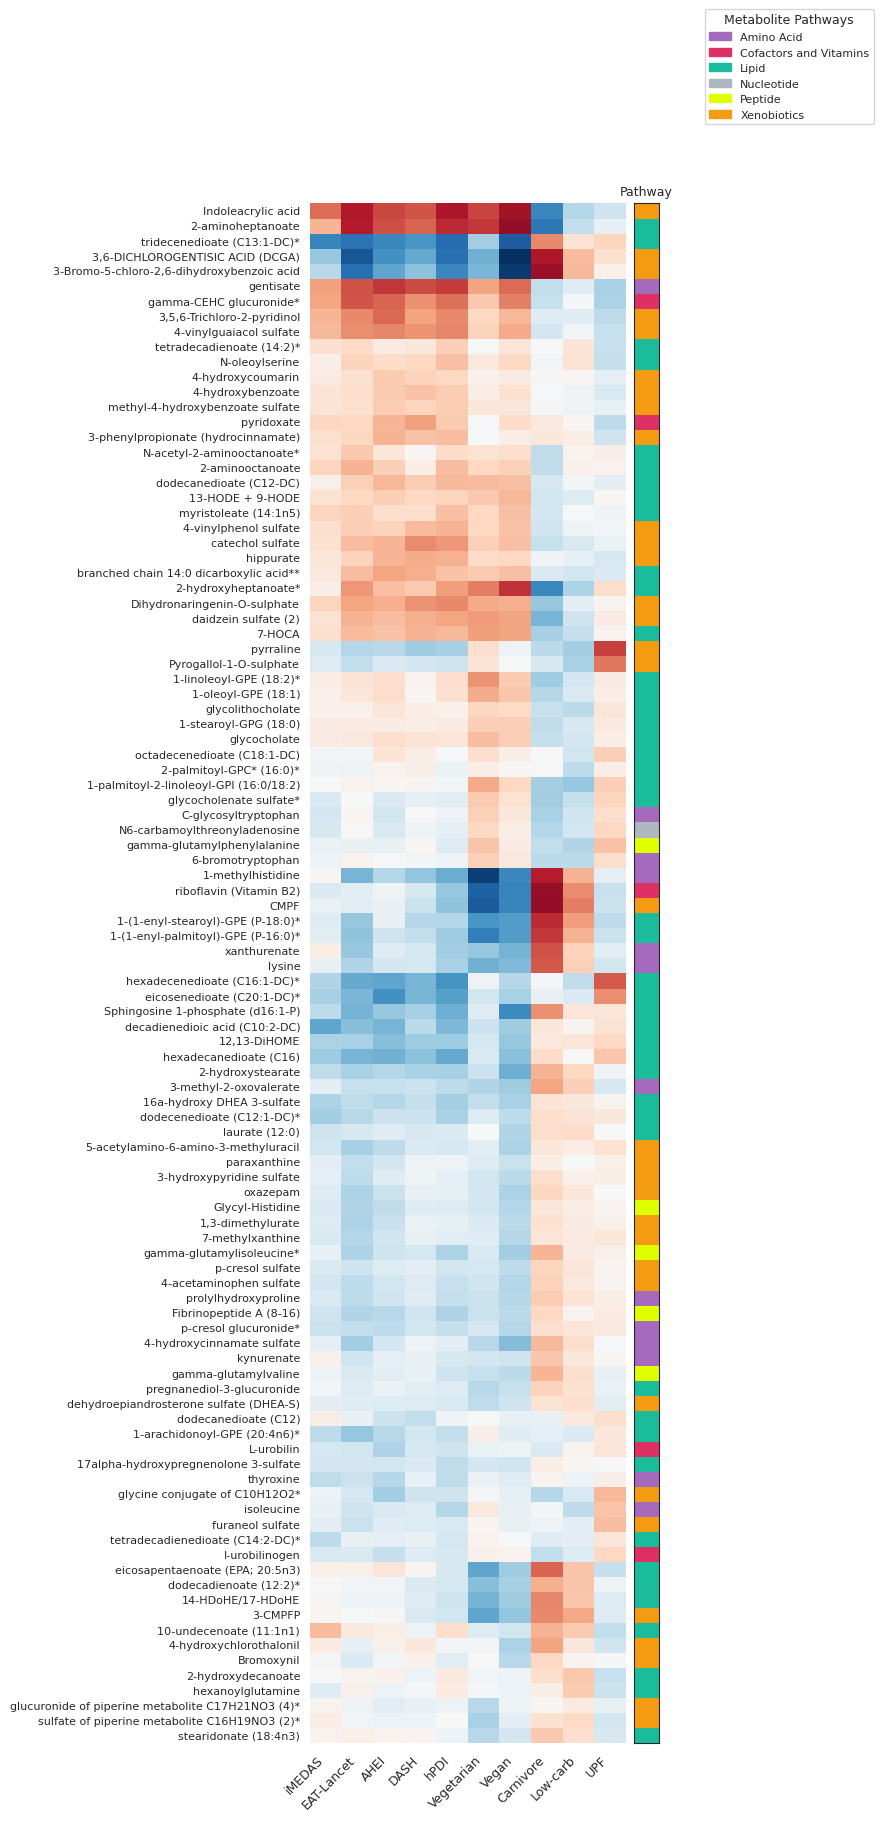

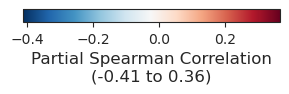

In [758]:
metabo_macthed_columns = matched_df_baseline.columns.to_list()[:-5]
fig, cbar_fig,  filterd_data = plot_metabolite_diet_correlation_heatmap(matched_df_baseline_diet_dropnan, metabo_macthed_columns, diet_scores, 
                                                             annotations_table=annotations, group_by_pathway=False, 
                                                             save_path=figs_dir + "/metabolite_diet_correlation_FINAL_based_copy.png", 
                                                             figsize=(4.5, 20), cmap='RdBu_r', title='', drop_unknowns=True, 
                                                             adjustment_method='fdr_bh',
                                                             correlation_threshold=0.1,
                                                             include_dendrogram=False, dendrogram_ratio=0.2,
                                                             separate_colorbar=True, colorbar_figsize=(3, 3), include_colorbar=False,
                                                             colorbar_orientation='horizontal',
                                                             colorbar_save_path=figs_dir + "/metabolite_diet_correlation_colorbar.png",)
    

In [ ]:
# metabo_cols = serrf_all.columns.to_list()[:-5]
# ms_baseline_diet = ms_baseline_diet.dropna(how='any', axis=0)
# fig, filterd_data = plot_metabolite_diet_correlations_unannotated(ms_baseline_diet, metabo_cols, diet_scores, 
#                                                                   save_path=figs_dir + "/metabolite_diet_correlation_unannotated.png",
#                                                                   figsize=(4.5, 30), cmap='RdBu_r', title='',  correlation_threshold=0.3)                            

In [77]:
filterd_data['correlation_matrix'].to_csv(figs_dir + "/metabolite_diet_correlation_heatmap_FINAL.csv")

In [78]:
filterd_data['displayed_compounds'].to_csv(figs_dir + "/metabolite_diet_correlation_compounds_list.csv")

AttributeError: 'list' object has no attribute 'to_csv'

## Correlation Comparison

In [101]:
def process_subject_group(subjects_group, baseline_filtered, followup_filtered, 
                          common_metabolites, diet_data, use_grouping=True):
    """
    Process a group of subjects and calculate correlations for each.
    This function will be called by each worker.
    """
    results = []
    
    for subject in subjects_group:
        # Get diet change info for this subject
        if subject not in diet_data['RegistrationCode'].values:
            continue
            
        if use_grouping:
            subject_group = diet_data.loc[
                diet_data['RegistrationCode'] == subject, 'diet_change_group'
            ].values[0]
        else:
            subject_group = 'All'
        
        subject_diet_change = diet_data.loc[
            diet_data['RegistrationCode'] == subject, 'diet_score_change'
        ].values[0]
        
        # Get metabolite values for this subject
        baseline_values = baseline_filtered.loc[
            baseline_filtered['RegistrationCode'] == subject, common_metabolites
        ].values.flatten()
        
        followup_values = followup_filtered.loc[
            followup_filtered['RegistrationCode'] == subject, common_metabolites
        ].values.flatten()
        
        # Calculate correlation
        if len(baseline_values) > 0 and len(followup_values) > 0:
            # Remove any pairs with NaN values
            valid_indices = ~(np.isnan(baseline_values) | np.isnan(followup_values))
            valid_count = sum(valid_indices)
            
            if valid_count > 1:  # Need at least 2 points for correlation
                corr, p_value = pearsonr(
                    baseline_values[valid_indices], 
                    followup_values[valid_indices]
                )
                
                results.append({
                    'subject_id': subject,
                    'correlation': corr,
                    'diet_change_group': subject_group,
                    'diet_change_value': subject_diet_change,
                    'metabolite_count': valid_count,
                    'p_value': p_value
                })
    
    return results

def calculate_metabolite_correlations(
    baseline_metabolites: pd.DataFrame,
    followup_metabolites: pd.DataFrame,
    diet_baseline: pd.DataFrame,
    diet_followup: pd.DataFrame,
    diet_score_column: str,
    quantile: float = 0.25,
    log_transform: bool = True,
    standardize: bool = True,
    n_workers: int = 10
) -> (pd.DataFrame, (float, float)):
    """
    Calculate correlations between baseline and follow-up metabolites.
    
    If quantile is None, calculates correlations for all subjects without group comparisons.
    If quantile is provided, compares subjects in the bottom 'quantile' vs. top 'quantile' of diet-score change.

    Parameters:
    -----------
    quantile : float or None
        If float, defines the quantile for extreme group comparison.
        If None, uses all subjects without grouping.

    Returns:
    --------
    results : pd.DataFrame
        Per-subject correlations and diet change info.
    (lower_thresh, upper_thresh) : tuple of floats or (None, None)
        The diet_score_change thresholds defining bottom and top quantiles.
        Returns (None, None) if quantile is None.
    """
    warnings.filterwarnings('ignore')
    id_col = 'RegistrationCode'

    # 1) Merge diet scores and compute absolute change
    diet_data = pd.merge(
        diet_baseline[[id_col, diet_score_column]],
        diet_followup[[id_col, diet_score_column]],
        on=id_col, suffixes=('_baseline', '_followup')
    )
    diet_data['diet_score_change'] = (
        diet_data[f'{diet_score_column}_followup'] -
        diet_data[f'{diet_score_column}_baseline']
    ).abs()

    # 2) Handle grouping based on quantile parameter
    if quantile is None:
        # No grouping - use all subjects
        print("Using all subjects without grouping")
        diet_data['diet_change_group'] = 'All'
        lower_thresh = None
        upper_thresh = None
        use_grouping = False
    else:
        # Compute lower and upper thresholds for extreme groups
        lower_thresh = diet_data['diet_score_change'].quantile(quantile)
        upper_thresh = diet_data['diet_score_change'].quantile(1 - quantile)
        print(f"Comparing bottom {quantile*100:.1f}% (<= {lower_thresh:.3f}) "
              f"vs. top {quantile*100:.1f}% (>= {upper_thresh:.3f})")

        # Label and keep only extremes
        diet_data['diet_change_group'] = 'Intermediate'
        diet_data.loc[diet_data['diet_score_change'] <= lower_thresh, 'diet_change_group'] = 'Small Change'
        diet_data.loc[diet_data['diet_score_change'] >= upper_thresh, 'diet_change_group'] = 'Large Change'
        diet_data = diet_data[diet_data['diet_change_group'].isin(['Small Change', 'Large Change'])]
        use_grouping = True

    # 3) Print group distribution
    counts = diet_data['diet_change_group'].value_counts()
    for grp, cnt in counts.items():
        pct = cnt / len(diet_data) * 100
        print(f"{grp}: {cnt} subjects ({pct:.1f}%)")

    # 4) Identify common subjects
    common_subjects = list(
        set(baseline_metabolites[id_col])
        & set(followup_metabolites[id_col])
        & set(diet_data[id_col])
    )
    if quantile is None:
        print(f"Number of subjects: {len(common_subjects)}")
    else:
        print(f"Number of subjects in extremes: {len(common_subjects)}")

    # 5) Determine common metabolites
    baseline_cols = [c for c in baseline_metabolites.columns[:-5] if c != id_col]
    followup_cols = [c for c in followup_metabolites.columns[:-5] if c != id_col]
    common_metabolites = sorted(set(baseline_cols) & set(followup_cols))
    if not common_metabolites:
        raise ValueError("No common metabolites found")
    print(f"Common metabolites: {len(common_metabolites)}")

    # 6) Filter data
    baseline_filtered = baseline_metabolites[
        baseline_metabolites[id_col].isin(common_subjects)
    ][[id_col] + common_metabolites].copy()
    followup_filtered = followup_metabolites[
        followup_metabolites[id_col].isin(common_subjects)
    ][[id_col] + common_metabolites].copy()

    # 7) Optional log-transform
    if log_transform:
        print("Applying log(x+1) transform")
        for col in common_metabolites:
            for df in (baseline_filtered, followup_filtered):
                min_val = df[col].min()
                offset = abs(min_val) + 1 if min_val <= 0 else 0
                df[col] = np.log(df[col] + offset + 1)

    # 8) Optional standardization
    if standardize:
        print("Standardizing metabolites")
        scaler = StandardScaler()
        baseline_filtered[common_metabolites] = scaler.fit_transform(baseline_filtered[common_metabolites])
        followup_filtered[common_metabolites] = scaler.fit_transform(followup_filtered[common_metabolites])

    # 9) Parallel processing setup
    n_workers = min(n_workers, mp.cpu_count())
    print(f"Using {n_workers} workers")
    np.random.shuffle(common_subjects)
    subject_groups = np.array_split(common_subjects, n_workers)
    worker_args = [
        (grp, baseline_filtered, followup_filtered, common_metabolites, diet_data, use_grouping)
        for grp in subject_groups
    ]

    # 10) Run in parallel
    from multiprocessing import Pool
    results_list = []
    with Pool(n_workers) as pool:
        chunks = pool.starmap(process_subject_group, worker_args)
    results_flat = [r for chunk in chunks for r in chunk]
    results = pd.DataFrame(results_flat)

    # 11) Summary stats and group comparison (only if using grouping)
    if use_grouping:
        for grp in ['Small Change', 'Large Change']:
            vals = results.loc[results['diet_change_group'] == grp, 'correlation']
            if len(vals):
                print(f"{grp}: mean={vals.mean():.3f}, median={vals.median():.3f}, n={len(vals)}")

        small_vals = results.loc[results['diet_change_group']=='Small Change','correlation']
        large_vals = results.loc[results['diet_change_group']=='Large Change','correlation']
        if len(small_vals) and len(large_vals):
            u_stat, p_val = mannwhitneyu(small_vals, large_vals, alternative='two-sided')
            print(f"Mann-Whitney U: U={u_stat:.1f}, p={p_val:.3f}")
    else:
        # Summary for all subjects
        vals = results['correlation']
        print(f"All subjects: mean={vals.mean():.3f}, median={vals.median():.3f}, n={len(vals)}")

    # 12) Summary table
    if use_grouping:
        summary = results.groupby('diet_change_group').agg({
            'correlation': ['mean','median','std','min','max','count'],
            'metabolite_count': ['mean','min','max']
        })
    else:
        summary = results.agg({
            'correlation': ['mean','median','std','min','max','count'],
            'metabolite_count': ['mean','min','max']
        })
    
    print("\nSummary:")
    print(summary)

    return results, (lower_thresh, upper_thresh)

In [102]:
def plot_metabolite_correlations(results, diet_score_column, change_threshold, 
                                n_bins=10, log_transform=True, standardize=True, fig_size = (12, 10),
                                figs_dir="./", show_bin_size=True):
    """
    Plot the results of metabolite correlation analysis with smooth histogram 
    and quantile binning visualization.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        DataFrame with correlation results from calculate_metabolite_correlations
    diet_score_column : str
        Name of the diet score column used in the analysis
    change_threshold : float
        Threshold used to classify diet change as small or large
    n_bins : int
        Number of quantile bins for the diet change values
    log_transform : bool
        Whether log transformation was applied (for labeling only)
    standardize : bool
        Whether standardization was applied (for labeling only)
    figs_dir : str
        Directory to save the figure
    """
    
    # Create subplots: kernel density plot and quantile binning plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fig_size, gridspec_kw={'height_ratios': [2, 1]})
    
    # Kernel density plot on top subplot - now with thick lines and no fill
    sns.kdeplot(
        data=results, x='correlation', hue='diet_change_group',
        fill=False, common_norm=False,
        ax=ax1, bw_adjust=0.8,  # Adjust bandwidth for smoothness
        linewidth=2.5  # Make lines thicker
    )
    
    transform_text = ""
    if log_transform:
        transform_text += "log(x+1) transformed, "
    if standardize:
        transform_text += "standardized, "
    if transform_text:
        transform_text = f"({transform_text.rstrip(', ')})"
    
    # ax1.set_title(f'Distribution of Metabolite Correlations By {diet_score_column} Change\n{transform_text}')
    ax1.set_xlabel('Pearson Correlation (Baseline vs. Follow-up)')
    ax1.set_ylabel('Density')
    ax1.grid(alpha=0.3)
        
    # Add mean lines and move annotations to the left of the lines
    for group in ['Small Change', 'Large Change']:
        group_corrs = results[results['diet_change_group'] == group]['correlation']
        if len(group_corrs) > 0:
            mean_corr = group_corrs.median()
            color = 'blue' if group == 'Small Change' else 'orange'
            ax1.axvline(mean_corr, color=color, linestyle='--', alpha=0.7)
            
            # Position text to the left of the mean line
            # Different vertical positions to avoid overlap between groups
            y_pos = ax1.get_ylim()[1] * (0.9 if group == 'Small Change' else 0.8)
            
            # Set offset based on group - larger negative offset for Small Change
            x_offset = -0.35 if group == 'Small Change' else 0.09
            
            ax1.text(
                mean_corr - x_offset,  # Position text to the left of the line
                y_pos,
                f'Median: {mean_corr:.3f}',
                color=color,
                ha='right',  # Right-align the text so it ends near the line
                bbox=dict(facecolor='white', alpha=0.8)
            )
    
    # Add t-test p-value to plot
    small_change = results[results['diet_change_group'] == 'Small Change']['correlation']
    large_change = results[results['diet_change_group'] == 'Large Change']['correlation']
    
    if len(small_change) > 0 and len(large_change) > 0:
        u_stat, p_val = stats.mannwhitneyu(small_change, large_change)
        ax1.text(
            0.05, 0.95,
            f"Mann-Whitney U test: p={p_val:.3f}",
            transform=ax1.transAxes,
            bbox=dict(facecolor='white', alpha=0.8)
        )
    
    # Quantile binning
    # Create quantile bins based on diet_change_value
    results['bin'] = pd.qcut(results['diet_change_value'], n_bins, labels=False)
    
    # Calculate bin edges for plotting
    bin_edges = pd.qcut(results['diet_change_value'], n_bins, retbins=True)[1]
    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    
    # Calculate median correlation for each bin
    bin_stats = results.groupby('bin').agg({
        'correlation': ['median', 'mean', 'count', 'std'],
        'diet_change_value': ['median', 'min', 'max']
    }).reset_index()
    
    # Calculate standard error for each bin (std/sqrt(n))
    bin_stats['correlation', 'se'] = bin_stats['correlation']['std'] / np.sqrt(bin_stats['correlation']['count'])
    
    # Color bins based on diet change (using threshold to identify large change bins)
    # First, determine which bins are mainly "large change" bins
    large_change_bins = []
    for b in range(n_bins):
        bin_data = results[results['bin'] == b]
        if bin_data.empty:
            continue
        # Count how many points in this bin are from large change group
        large_count = sum(bin_data['diet_change_group'] == 'Large Change')
        # If more than 50% are large change, mark this bin
        if large_count / len(bin_data) > 0.5:
            large_change_bins.append(b)
    
    # Plot median correlation for each bin with appropriate color
    bar_colors = []
    for b in range(n_bins):
        if b in large_change_bins:
            bar_colors.append('orange')  # Large change bins in orange
        else:
            bar_colors.append('lightblue')  # Small change bins in lightblue
    
    ax2.bar(
        bin_centers, 
        bin_stats['correlation']['median'],
        width=(bin_edges[1] - bin_edges[0]) * 0.8,  # Make bars slightly narrower than bins
        alpha=0.7,
        color=bar_colors,
        edgecolor='navy'
    )
    
    # Add error bars (using standard error instead of standard deviation)
    ax2.errorbar(
        bin_centers,
        bin_stats['correlation']['median'],
        yerr=bin_stats['correlation']['se'],  # Using standard error now
        fmt='none',
        color='navy',
        capsize=5
    )
    
    # Remove individual count labels from bars
    # Add a text box in the upper right corner showing the bin size
    avg_count = int(bin_stats['correlation']['count'].mean())
    ax2.text(
        0.95, 0.95,
        f'Bin size: n={avg_count}',
        transform=ax2.transAxes,
        ha='right',
        va='top',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5')
    )
    
    # ax2.set_title('Median Correlation by Diet Score Change (Quantile Bins)')
    ax2.set_xlabel(f'Absolute change in {diet_score_column}')
    ax2.set_ylabel('Median Pearson correlation')
    ax2.grid(alpha=0.3)
    
    # Use regular ticks for x-axis instead of bin ranges
    # Set approximately 5-6 ticks across the range of diet change values
    min_change = min(bin_edges)
    max_change = max(bin_edges)
    
    # Calculate a nice interval for ticks
    tick_range = max_change - min_change
    tick_step = round(tick_range / 5, 1)  # Round to 1 decimal place for clean ticks
    
    # Generate evenly spaced ticks
    x_ticks = np.arange(
        round(min_change, 1),  # Round the min value for clean starting point
        max_change + tick_step,  # Add extra step to ensure we include the max
        tick_step
    )
    
    # Apply the new ticks
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels([f"{x:.1f}" for x in x_ticks], rotation=0)
    
    # Add trend line using bin centers and medians
    z = np.polyfit(bin_centers, bin_stats['correlation']['median'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(min(bin_centers), max(bin_centers), 100)
    ax2.plot(x_trend, p(x_trend), 'r--', alpha=0.7)
    
    # Set custom y-axis limits for bottom plot (0.4 to 0.55)
    ax2.set_ylim(0.4, 0.52)
    
    # Make sure ticks are properly set
    ax2.yaxis.set_major_locator(plt.MultipleLocator(0.05))  # Set major ticks every 0.05
    ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))  # Format to show 2 decimal places
    
    plt.tight_layout()
    filename = 'metabolite_correlations_smooth_binned_new'
    if log_transform:
        filename += 'log_'
    if standardize:
        filename += 'std_'
    filename += f'diet_change_{diet_score_column}.png'
    filename_pdf = filename.replace('.png', '.pdf')
    plt.savefig(figs_dir + filename, dpi=300)
    plt.savefig(figs_dir + filename_pdf)
    plt.show()
    
    # Create bin statistics table
    bin_table = pd.DataFrame({
        'Bin Range': [f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)],
        'Median Correlation': bin_stats['correlation']['median'],
        'Mean Correlation': bin_stats['correlation']['mean'],
        'Count': bin_stats['correlation']['count'],
        'Min Diet Change': bin_stats['diet_change_value']['min'],
        'Max Diet Change': bin_stats['diet_change_value']['max']
    })
    
    print("\nBin Statistics:")
    print(bin_table)
    
    return fig, bin_table

In [260]:
diet_scores

['IMEDAS_score_per_day',
 'eatLANCET_score_per_day',
 'aHEI_score_per_day',
 'DASH_score',
 'hPDI_score_per_day',
 'vegetarian_score_per_day',
 'vegan_score_per_day',
 'carnivore_score_per_day',
 'low_carb_diet',
 'pct_NOVA_4']

In [390]:
diet_type_compare = 'pct_NOVA_4'

In [391]:
results, threshold = calculate_metabolite_correlations(
    ms_baseline, ms_2y,
    diet_features.reset_index(), diet_features_v2_02.reset_index(),
    diet_type_compare, log_transform=True, standardize=True, n_workers=20, quantile=None
)

Using all subjects without grouping
All: 4376 subjects (100.0%)
Number of subjects: 2243
Common metabolites: 2247
Applying log(x+1) transform
Standardizing metabolites
Using 20 workers
All subjects: mean=0.457, median=0.472, n=2243

Summary:
        correlation  metabolite_count
mean       0.456734            2247.0
median     0.471988               NaN
std        0.148781               NaN
min       -0.231160            2247.0
max        0.796894            2247.0
count   2243.000000               NaN


In [392]:
def plot_metabolite_correlations_binned_with_break(results, diet_score_column, 
                                                  n_bins=10, log_transform=True, standardize=True, 
                                                  fig_size=(10, 8), figs_dir="./",
                                                  axis_break=None, show_bin_size=True, show_trend_line=True):
    """
    Plot metabolite correlation analysis with quantile binning visualization and optional axis break.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        DataFrame with correlation results from calculate_metabolite_correlations
    diet_score_column : str
        Name of the diet score column used in the analysis
    n_bins : int
        Number of quantile bins for the diet change values
    log_transform : bool
        Whether log transformation was applied (for labeling only)
    standardize : bool
        Whether standardization was applied (for labeling only)
    fig_size : tuple
        Figure size (width, height)
    figs_dir : str
        Directory to save the figure
    axis_break : dict or None
        Dictionary with 'lower' and 'upper' keys specifying y-axis ranges.
        Example: {'lower': [0, 0.2], 'upper': [0.8, 1.0]}
        If None, uses standard single axis plot.
    """
    
    # 1??  Add jitter or rank?based assignment *once* and get edges back
    dcv = results['diet_change_value']
    # If you kept the tiny?jitter solution:
    dcv = dcv + np.random.default_rng(42).uniform(-1e-9, 1e-9, len(dcv))
    
    # One call only
    results['bin'], bin_edges = pd.qcut(
        dcv, n_bins, labels=False, retbins=True, duplicates='raise'   # or duplicates='drop' if you prefer
    )
    
    # 2??  Now compute bin_centers directly from those edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width   = (bin_edges[1] - bin_edges[0]) * 0.8  # as you did before

    
    # Calculate median correlation for each bin
    bin_stats = results.groupby('bin').agg({
        'correlation': ['median', 'mean', 'count', 'std'],
        'diet_change_value': ['median', 'min', 'max']
    }).reset_index()
    
    # Calculate standard error for each bin (std/sqrt(n))
    bin_stats['correlation', 'se'] = bin_stats['correlation']['std'] / np.sqrt(bin_stats['correlation']['count'])
    
    # Determine if we need axis break
    if axis_break is None:
        # Standard single axis plot
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        axes = [ax]
    else:
        # Create broken axis plot
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=fig_size)
        fig.subplots_adjust(hspace=0.05)  # adjust space between Axes
        axes = [ax1, ax2]
    
    # Plot data on all axes
    for i, ax in enumerate(axes):
        # Plot median correlation for each bin
        bars = ax.bar(
            bin_centers, 
            bin_stats['correlation']['median'],
            width=(bin_edges[1] - bin_edges[0]) * 0.8,  # Make bars slightly narrower than bins
            alpha=0.7,
            color='steelblue',
            edgecolor='navy'
        )
        
        # For broken axis, only add error bars and trend line to upper axis (ax1)
        # For single axis, always add them (i==0 in single axis case)
        if axis_break is None or i == 0:
            # Add error bars (using standard error)
            ax.errorbar(
                bin_centers,
                bin_stats['correlation']['median'],
                yerr=bin_stats['correlation']['se'],
                fmt='none',
                color='navy',
                capsize=5
            )
            
            # Add trend line using bin centers and medians
            z = np.polyfit(bin_centers, bin_stats['correlation']['median'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(min(bin_centers), max(bin_centers), 100)
            ax.plot(x_trend, p(x_trend), 'r--', alpha=0.7, linewidth=2)
        
        # Set grid
        ax.grid(alpha=0.3)
        
        # Set y-axis formatting
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    
    # Configure axis breaks if needed
    if axis_break is not None:
        ax1, ax2 = axes[0], axes[1]
        
        # Calculate the scale factor to maintain consistent visual proportions
        upper_range = axis_break['upper'][1] - axis_break['upper'][0]
        lower_range = axis_break['lower'][1] - axis_break['lower'][0]
        total_visible_range = upper_range + lower_range
        
        # Adjust subplot heights to match the actual data ranges
        # This ensures 1 unit of correlation value takes the same vertical space in both plots
        upper_height = upper_range / total_visible_range
        lower_height = lower_range / total_visible_range
        
        # Recreate the subplots with proportional heights
        fig.clear()
        gs = fig.add_gridspec(2, 1, height_ratios=[upper_height, lower_height], hspace=0.15)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        axes = [ax1, ax2]
        
        # Replot the data with the new axes
        for i, ax in enumerate(axes):
            # Plot median correlation for each bin
            bars = ax.bar(
                bin_centers, 
                bin_stats['correlation']['median'],
                width=(bin_edges[1] - bin_edges[0]) * 0.8,  # Make bars slightly narrower than bins
                alpha=0.7,
                color='steelblue',
                edgecolor='navy'
            )
            
            # For broken axis, only add error bars and trend line to upper axis (ax1)
            # For single axis, always add them (i==0 in single axis case)
            if axis_break is None or i == 0:
                # Add error bars (using standard error)
                ax.errorbar(
                    bin_centers,
                    bin_stats['correlation']['median'],
                    yerr=bin_stats['correlation']['se'],
                    fmt='none',
                    color='navy',
                    capsize=5
                )
                
                # Add trend line using bin centers and medians
                z = np.polyfit(bin_centers, bin_stats['correlation']['median'], 1)
                p = np.poly1d(z)
                x_trend = np.linspace(min(bin_centers), max(bin_centers), 100)
                ax.plot(x_trend, p(x_trend), 'r--', alpha=0.7, linewidth=2)
            
            # Set grid
            ax.grid(alpha=0.3)
            
            # Set y-axis formatting
            ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        
        # Set the axis limits to the specified ranges
        ax1.set_ylim(axis_break['upper'])  # upper portion
        ax2.set_ylim(axis_break['lower'])  # lower portion
        

# Custom y-axis ticks for broken axis
        if axis_break is not None:
            # Generate ticks at 0.05 intervals for upper axis
            upper_min, upper_max = axis_break['upper']
            upper_ticks = np.arange(
                np.ceil(upper_min / 0.05) * 0.05,  # Round up to nearest 0.05
                upper_max + 0.05,
                0.05
            )
            # Filter ticks to only include those within the range
            upper_ticks = upper_ticks[(upper_ticks >= upper_min) & (upper_ticks <= upper_max)]
            ax1.set_yticks(upper_ticks)
            
            # Generate ticks at 0.05 intervals for lower axis
            lower_min, lower_max = axis_break['lower']
            lower_ticks = np.arange(
                np.ceil(lower_min / 0.05) * 0.05,  # Round up to nearest 0.05
                lower_max + 0.05,
                0.05
            )
            # Filter ticks to only include those within the range
            lower_ticks = lower_ticks[(lower_ticks >= lower_min) & (lower_ticks <= lower_max)]
            ax2.set_yticks(lower_ticks)
        else:
            # For single axis, generate ticks at 0.05 intervals
            y_min, y_max = ax.get_ylim()
            y_ticks = np.arange(
                np.ceil(y_min / 0.05) * 0.05,  # Round up to nearest 0.05
                y_max + 0.05,
                0.05
            )
            # Filter ticks to only include those within the range
            y_ticks = y_ticks[(y_ticks >= y_min) & (y_ticks <= y_max)]
            ax.set_yticks(y_ticks)
        
        # Hide the spines between ax1 and ax2
        ax1.spines.bottom.set_visible(False)
        ax2.spines.top.set_visible(False)
        ax1.tick_params(bottom=False)  # Remove ticks from upper axis bottom   
        ax1.xaxis.tick_top()
        ax1.tick_params(labeltop=False)  # don't put tick labels at the top
        ax2.xaxis.tick_bottom()
        
        # Add break lines
        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                      linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
        ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
        
        # Add labels - only bottom axis gets x-label
        ax2.set_xlabel(f'Absolute change in {diet_score_column}')
        
        # Y-label goes on the middle axis (ax2 in this case)
        # ax2.set_ylabel('Median Pearson Correlation')
        
        # Title goes on top axis
        transform_text = ""
        if log_transform:
            transform_text += "log(x+1) transformed, "
        if standardize:
            transform_text += "standardized, "
        if transform_text:
            transform_text = f"({transform_text.rstrip(', ')})"
        
        # ax1.set_title(f'Median Correlation by {diet_score_column} Change (Quantile Bins)\n{transform_text}')
        
        # Add text boxes to appropriate axes
        if show_bin_size:
            # Bin size info on upper axis
            avg_count = int(bin_stats['correlation']['count'].mean())
            ax1.text(
                0.95, 0.95,
                f'Bin size: n={avg_count}',
                transform=ax1.transAxes,
                ha='right',
                va='top',
                fontsize=10,
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5')
            )
        if show_trend_line:
            # Trend statistics on lower axis
            slope = z[0]
            r_squared = np.corrcoef(bin_centers, bin_stats['correlation']['median'])[0, 1]**2
            ax2.text(
                0.05, 0.95,
                f'Trend: slope={slope:.2f}, R²={r_squared:.2f}',
                transform=ax2.transAxes,
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5')
            )
        
    else:
        # Standard single axis configuration
        ax = axes[0]
        
        if show_bin_size:
            # Add text boxes
            avg_count = int(bin_stats['correlation']['count'].mean())
            ax.text(
                0.95, 0.95,
                f'Bin size: n={avg_count}',
                transform=ax.transAxes,
                ha='right',
                va='top',
                fontsize=10,
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5')
            )
        
        if show_trend_line:
            # Add trend line statistics
            slope = z[0]
            r_squared = np.corrcoef(bin_centers, bin_stats['correlation']['median'])[0, 1]**2
            ax.text(
                0.05, 0.95,
                f'Trend: slope={slope:.2f}, R²={r_squared:.2f}',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5')
            )
        
        # Set labels and title
        transform_text = ""
        if log_transform:
            transform_text += "log(x+1) transformed, "
        if standardize:
            transform_text += "standardized, "
        if transform_text:
            transform_text = f"({transform_text.rstrip(', ')})"
        
        ax.set_xlabel(f'Absolute change in {diet_score_column}')
        ax.set_ylabel('Median pearson correlation')
    
    # Set x-axis ticks and limits (applies to all configurations)
    # Use bin centers for tight limits, not the sample range
    min_bin_center = min(bin_centers)
    max_bin_center = max(bin_centers)
    
    # Make x-axis limits tighter - add small padding based on bin spacing
    # bin_width = bin_centers[1] - bin_centers[0] if len(bin_centers) > 1 else 0.1
    padding = bin_width * 2  # 60% of bin width padding on each side
    x_min_tight = min_bin_center - padding
    x_max_tight = max_bin_center + padding
    
    # Calculate a nice interval for ticks based on bin centers
    bin_range = max_bin_center - min_bin_center
    tick_step = round(bin_range / 5, 1)  # Round to 1 decimal place for clean ticks
    
    # Generate evenly spaced ticks
    x_ticks = np.arange(
        round(min_bin_center, 1),  # Round the min value for clean starting point
        max_bin_center + tick_step,  # Add extra step to ensure we include the max
        tick_step
    )
    
    # Apply the new ticks and limits to the appropriate axis
    if axis_break is not None:
        ax2.set_xticks(x_ticks)
        ax2.set_xticklabels([f"{x:.1f}" for x in x_ticks], rotation=0)
        ax2.set_xlim(x_min_tight, x_max_tight)
        ax1.set_xlim(x_min_tight, x_max_tight)  # Make sure both axes have same x limits
    else:
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f"{x:.1f}" for x in x_ticks], rotation=0)
        ax.set_xlim(x_min_tight, x_max_tight)
    
    plt.tight_layout()
    
    # Save figure
    filename = 'metabolite_correlations_binned'
    if axis_break is not None:
        filename += '_broken_axis'
    if log_transform:
        filename += '_log'
    if standardize:
        filename += '_std'
    filename += f'_diet_change_{diet_score_column}.png'
    filename_pdf = filename.replace('.png', '.pdf')
    plt.savefig(figs_dir + filename, dpi=300, bbox_inches='tight')
    plt.savefig(figs_dir + filename_pdf, bbox_inches='tight')
    plt.show()
    
    # Create bin statistics table
    bin_table = pd.DataFrame({
        'Bin Range': [f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)],
        'Median Correlation': bin_stats['correlation']['median'],
        'Mean Correlation': bin_stats['correlation']['mean'],
        'Count': bin_stats['correlation']['count'],
        'Min Diet Change': bin_stats['diet_change_value']['min'],
        'Max Diet Change': bin_stats['diet_change_value']['max']
    })
    
    print("\nBin Statistics:")
    print(bin_table)
    
    return fig, bin_table


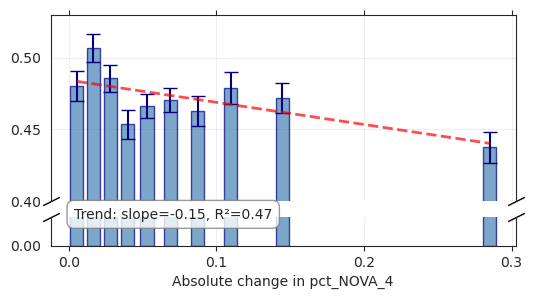


Bin Statistics:
  Bin Range  Median Correlation  Mean Correlation  Count  Min Diet Change  \
0  -0.0-0.0            0.480120          0.469338    225         0.000000   
1   0.0-0.0            0.506749          0.484014    224         0.011083   
2   0.0-0.0            0.485511          0.471969    224         0.022136   
3   0.0-0.0            0.453323          0.443735    224         0.034034   
4   0.0-0.1            0.466177          0.471692    225         0.046280   
5   0.1-0.1            0.470309          0.453492    224         0.059833   
6   0.1-0.1            0.462492          0.446701    224         0.077574   
7   0.1-0.1            0.478564          0.449716    224         0.097244   
8   0.1-0.2            0.471923          0.451453    224         0.122477   
9   0.2-0.4            0.437295          0.425246    225         0.167038   

   Max Diet Change  
0         0.011067  
1         0.022103  
2         0.033986  
3         0.046278  
4         0.059821  
5        

In [393]:
fig = plot_metabolite_correlations_binned_with_break(
    results, diet_type_compare, 
    n_bins=10, log_transform=True, standardize=True, figs_dir=figs_dir, fig_size=(6, 3), axis_break={'lower': [0, 0.02], 'upper': [0.4, 0.53]},
    show_bin_size=False, show_trend_line=True)

In [373]:
def plot_metabolite_correlations_boxplot_with_break(results, diet_score_column, 
                                                   n_bins=10, log_transform=True, standardize=True, 
                                                   fig_size=(10, 8), figs_dir="./",
                                                   axis_break=None):
    """
    Plot metabolite correlation analysis with quantile binning visualization using boxplots and optional axis break.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        DataFrame with correlation results from calculate_metabolite_correlations
    diet_score_column : str
        Name of the diet score column used in the analysis
    n_bins : int
        Number of quantile bins for the diet change values
    log_transform : bool
        Whether log transformation was applied (for labeling only)
    standardize : bool
        Whether standardization was applied (for labeling only)
    fig_size : tuple
        Figure size (width, height)
    figs_dir : str
        Directory to save the figure
    axis_break : dict or None
        Dictionary with 'lower' and 'upper' keys specifying y-axis ranges.
        Example: {'lower': [0, 0.2], 'upper': [0.8, 1.0]}
        If None, uses standard single axis plot.
    """
    
    # Create quantile bins based on diet_change_value
    results['bin'] = pd.qcut(results['diet_change_value'], n_bins, labels=False)
    
    # Calculate bin edges for labeling
    bin_edges = pd.qcut(results['diet_change_value'], n_bins, retbins=True)[1]
    
    # Create equally spaced x positions for boxplots (not proportional to bin values)
    x_positions = np.arange(n_bins)
    
    # Prepare data for boxplots - list of correlation values for each bin
    boxplot_data = []
    bin_labels = []
    
    for i in range(n_bins):
        bin_correlations = results[results['bin'] == i]['correlation'].values
        boxplot_data.append(bin_correlations)
        bin_labels.append(f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}")
    
    # Calculate bin statistics for trend line and table
    bin_stats = results.groupby('bin').agg({
        'correlation': ['median', 'mean', 'count', 'std'],
        'diet_change_value': ['median', 'min', 'max']
    }).reset_index()
    
    # Determine if we need axis break
    if axis_break is None:
        # Standard single axis plot
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        axes = [ax]
    else:
        # Create broken axis plot
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=fig_size)
        fig.subplots_adjust(hspace=0.05)  # adjust space between Axes
        axes = [ax1, ax2]
    
    # Plot data on all axes
    for i, ax in enumerate(axes):
        # Create boxplots
        bp = ax.boxplot(boxplot_data, 
                       positions=x_positions,
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7),
                       medianprops=dict(color='darkblue', linewidth=2),
                       whiskerprops=dict(color='darkblue'),
                       capprops=dict(color='darkblue'),
                       flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.5))
        
        # For broken axis, only add trend line to upper axis (ax1)
        # For single axis, always add it (i==0 in single axis case)
        if axis_break is None or i == 0:
            # Add trend line using bin medians and equally spaced positions
            medians = bin_stats['correlation']['median'].values
            z = np.polyfit(x_positions, medians, 1)
            p = np.poly1d(z)
            ax.plot(x_positions, p(x_positions), 'r--', alpha=0.7, linewidth=2, label='Trend')
        
        # Set grid
        ax.grid(alpha=0.3)
        
        # Set y-axis formatting
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    
    # Configure axis breaks if needed
    if axis_break is not None:
        ax1, ax2 = axes[0], axes[1]
        
        # Calculate the scale factor to maintain consistent visual proportions
        upper_range = axis_break['upper'][1] - axis_break['upper'][0]
        lower_range = axis_break['lower'][1] - axis_break['lower'][0]
        total_visible_range = upper_range + lower_range
        
        # Adjust subplot heights to match the actual data ranges
        upper_height = upper_range / total_visible_range
        lower_height = lower_range / total_visible_range
        
        # Recreate the subplots with proportional heights
        fig.clear()
        gs = fig.add_gridspec(2, 1, height_ratios=[upper_height, lower_height], hspace=0.15)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        axes = [ax1, ax2]
        
        # Replot the data with the new axes
        for i, ax in enumerate(axes):
            # Create boxplots
            bp = ax.boxplot(boxplot_data, 
                           positions=x_positions,
                           patch_artist=True,
                           boxprops=dict(facecolor='lightblue', alpha=0.7),
                           medianprops=dict(color='darkblue', linewidth=2),
                           whiskerprops=dict(color='darkblue'),
                           capprops=dict(color='darkblue'),
                           flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.5))
            
            # For broken axis, only add trend line to upper axis (ax1)
            if axis_break is None or i == 0:
                # Add trend line using bin medians and equally spaced positions
                medians = bin_stats['correlation']['median'].values
                z = np.polyfit(x_positions, medians, 1)
                p = np.poly1d(z)
                ax.plot(x_positions, p(x_positions), 'r--', alpha=0.7, linewidth=2, label='Trend')
            
            # Set grid
            ax.grid(alpha=0.3)
            
            # Set y-axis formatting
            ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        
        # Set the axis limits to the specified ranges
        ax1.set_ylim(axis_break['upper'])  # upper portion
        ax2.set_ylim(axis_break['lower'])  # lower portion
        
        # Hide the spines between ax1 and ax2
        ax1.spines.bottom.set_visible(False)
        ax2.spines.top.set_visible(False)
        ax1.xaxis.tick_top()
        ax1.tick_params(labeltop=False)  # don't put tick labels at the top
        ax2.xaxis.tick_bottom()
        
        # Add break lines
        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                      linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
        ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
        
        # Set x-axis labels and ticks
        ax2.set_xticks(x_positions)
        ax2.set_xticklabels(bin_labels, rotation=45, ha='right')
        ax2.set_xlabel(f'Quantile Bins of Absolute change in {diet_score_column}')
        
        # Y-label goes on the middle axis (ax2 in this case)
        ax2.set_ylabel('Pearson Correlation')
        
        # Title goes on top axis
        transform_text = ""
        if log_transform:
            transform_text += "log(x+1) transformed, "
        if standardize:
            transform_text += "standardized, "
        if transform_text:
            transform_text = f"({transform_text.rstrip(', ')})"
        
        ax1.set_title(f'Correlation Distribution by {diet_score_column} Change (Quantile Bins)\n{transform_text}')
        
        # Add text boxes to appropriate axes
        # Total sample size on upper axis
        total_count = len(results)
        ax1.text(
            0.95, 0.95,
            f'Total n={total_count}',
            transform=ax1.transAxes,
            ha='right',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5')
        )
        
        # Trend statistics on lower axis
        medians = bin_stats['correlation']['median'].values
        slope = z[0]
        r_squared = np.corrcoef(x_positions, medians)[0, 1]**2
        ax2.text(
            0.05, 0.95,
            f'Trend: slope={slope:.4f}, R²={r_squared:.3f}',
            transform=ax2.transAxes,
            bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5')
        )
        
    else:
        # Standard single axis configuration
        ax = axes[0]
        
        # Set x-axis labels and ticks
        ax.set_xticks(x_positions)
        ax.set_xticklabels(bin_labels, rotation=45, ha='right')
        
        # Add text boxes
        total_count = len(results)
        ax.text(
            0.95, 0.95,
            f'bin size={total_count // n_bins}',
            transform=ax.transAxes,
            ha='right',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5')
        )
        
        
        # Set labels and title
        transform_text = ""
        if log_transform:
            transform_text += "log(x+1) transformed, "
        if standardize:
            transform_text += "standardized, "
        if transform_text:
            transform_text = f"({transform_text.rstrip(', ')})"
        
        # ax.set_title(f'Correlation Distribution by {diet_score_column} Change (Quantile Bins)\n{transform_text}')
        ax.set_xlabel(f'Quantile Bins of Absolute Change in {diet_score_column}')
        ax.set_ylabel('Pearson Correlation')
    
    plt.tight_layout()
    
    # Save figure
    filename = 'metabolite_correlations_boxplot'
    if axis_break is not None:
        filename += '_broken_axis'
    if log_transform:
        filename += '_log'
    if standardize:
        filename += '_std'
    filename += f'_diet_change_{diet_score_column}.png'
    filename_pdf = filename.replace('.png', '.pdf')
    plt.savefig(figs_dir + filename, dpi=300, bbox_inches='tight')
    plt.savefig(figs_dir + filename_pdf, bbox_inches='tight')
    plt.show()
    
    # Create bin statistics table
    bin_table = pd.DataFrame({
        'Bin Range': bin_labels,
        'Median Correlation': bin_stats['correlation']['median'],
        'Mean Correlation': bin_stats['correlation']['mean'],
        'Count': bin_stats['correlation']['count'],
        'Std Correlation': bin_stats['correlation']['std'],
        'Min Diet Change': bin_stats['diet_change_value']['min'],
        'Max Diet Change': bin_stats['diet_change_value']['max']
    })
    
    print("\nBin Statistics:")
    print(bin_table)
    
    return fig, bin_table

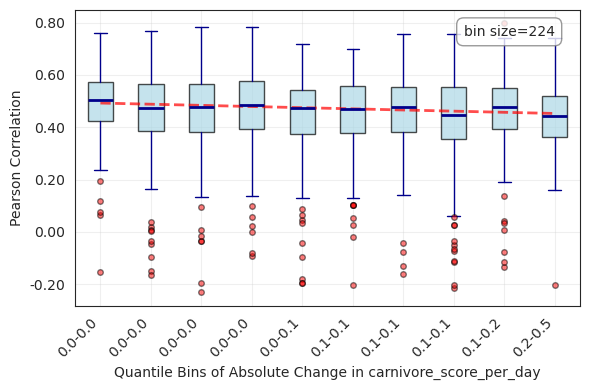


Bin Statistics:
  Bin Range  Median Correlation  Mean Correlation  Count  Std Correlation  \
0   0.0-0.0            0.504752          0.492830    225         0.127879   
1   0.0-0.0            0.474609          0.461165    224         0.154036   
2   0.0-0.0            0.478917          0.458382    224         0.159711   
3   0.0-0.0            0.484421          0.476957    224         0.145257   
4   0.0-0.1            0.473169          0.443057    225         0.158745   
5   0.1-0.1            0.468213          0.455072    224         0.145896   
6   0.1-0.1            0.478371          0.459162    224         0.136647   
7   0.1-0.1            0.446627          0.424081    224         0.174751   
8   0.1-0.2            0.476756          0.458934    224         0.143727   
9   0.2-0.5            0.442505          0.437683    225         0.125955   

   Min Diet Change  Max Diet Change  
0         0.000000         0.008100  
1         0.008128         0.018572  
2         0.018580   

In [372]:
fig = plot_metabolite_correlations_boxplot_with_break(
    results, diet_type_compare, 
    n_bins=10, log_transform=True, standardize=True, figs_dir=figs_dir, fig_size=(6, 4),
)

## Cardio 10K

In [401]:
from LabData.DataLoaders import SubjectLoader, BodyMeasuresLoader

In [402]:
subject_loader = SubjectLoader.SubjectLoader()
body_measures_loader = BodyMeasuresLoader.BodyMeasuresLoader()

In [407]:
cardio_10k = subject_loader.get_data(study_ids=[1001]).df
bm_cardio_10k = body_measures_loader.get_data(study_ids=[1001]).df.join(body_measures_loader.get_data(study_ids=[1001]).df_metadata['research_stage'])

In [414]:
bm_cardio_10k_baseline = bm_cardio_10k[bm_cardio_10k['research_stage'] == 'baseline'].reset_index()
bm_cardio_10k_baseline.set_index('RegistrationCode', inplace=True)

In [418]:
baseline_10k_cardio_conditions = pd.read_csv('/net/mraid20/export/genie/LabData/Data/10K/for_review/baseline_conditions_beilinson.csv')

In [436]:
# if conditions are Acute myocardial infarction or Coronary atherosclerosis create a bollean column 'ischemic'
baseline_10k_cardio_conditions['ischemic'] = baseline_10k_cardio_conditions['english_name'].astype(str).apply(lambda x: 'Acute myocardial infarction' in x or 'Coronary atherosclerosis' in x or 'Angina pectoris' in x or 'Atherosclerotic chronic arterial occlusive disease' in x)

In [437]:
baseline_10k_cardio_conditions['ischemic'].value_counts()

ischemic
False    639
True      99
Name: count, dtype: int64

In [448]:
baseline_10k_cardio_conditions['RegistrationCode']

0      10K_1025749239
1      10K_1025749239
2      10K_1025749239
3      10K_1036985980
4      10K_1079867922
            ...      
733    10K_9192697991
734    10K_9287612409
735    10K_9337441943
736    10K_9461912685
737    10K_9811487537
Name: RegistrationCode, Length: 738, dtype: object

In [458]:
baseline_10k_cardio_conditions['RegistrationCode']

0      10K_1025749239
1      10K_1025749239
2      10K_1025749239
3      10K_1036985980
4      10K_1079867922
            ...      
733    10K_9192697991
734    10K_9287612409
735    10K_9337441943
736    10K_9461912685
737    10K_9811487537
Name: RegistrationCode, Length: 738, dtype: object

In [450]:
matched_df_baseline_diet_cardio = matched_df_baseline_diet_dropnan.merge(baseline_10k_cardio_conditions, on='RegistrationCode', how='inner')

In [464]:
serrf_all_cardio = serrf_all.merge(baseline_10k_cardio_conditions, on='RegistrationCode', how='inner')

In [467]:
serrf_all_cardio['ischemic'].value_counts()

ischemic
False    441
True      65
Name: count, dtype: int64

In [472]:
serrf_all_cardio['research_stage'].value_counts()

research_stage
baseline       305
02_00_visit    169
01_01_visit     19
03_01_visit     12
04_00_visit      1
Name: count, dtype: int64

In [473]:
serrf_all_cardio[['research_stage', 'ischemic']].value_counts()

research_stage  ischemic
baseline        False       263
02_00_visit     False       150
baseline        True         42
02_00_visit     True         19
01_01_visit     False        16
03_01_visit     False        11
01_01_visit     True          3
03_01_visit     True          1
04_00_visit     False         1
Name: count, dtype: int64

In [474]:
serrf_all_cardio_baseline = serrf_all_cardio[serrf_all_cardio['research_stage'] == 'baseline']

In [477]:
serrf_all_cardio_baseline['ischemic'].value_counts()

ischemic
False    263
True      42
Name: count, dtype: int64

In [ ]:
matched_df_cardio, column_mapping_cardio = match_metabolite_columns(serrf_all_cardio_baseline, annotations)

In [512]:
matched_df_cardio_hc = pd.concat([matched_df_cardio, matched_df])

In [526]:
matched_df_cardio_hc['is_cardio'] = matched_df_cardio_hc['medical_condition'].apply(lambda x: 0 if pd.isna(x) else 1)

In [527]:
matched_df_cardio_hc['is_cardio'].value_counts()

is_cardio
0    10057
1      305
Name: count, dtype: int64

In [657]:
def mann_whitney_analysis(df, condition_col, alpha=0.05, cols_for_compare=None, apply_scaling=True):
    """
    Perform Mann-Whitney U test on all numeric columns according to a condition column.
    Apply FDR-BH correction for multiple testing.
    
    Parameters:
    - df: DataFrame containing the data
    - condition_col: Column name indicating the condition (binary grouping variable)
    - alpha: Significance level for FDR correction (default: 0.05)
    - cols_for_compare: List of column names to compare (default: None, uses all numeric columns)
    - apply_scaling: Whether to apply standard scaling and clip to [-3, 3] range (default: True)
    
    Returns:
    - results_df: DataFrame with test results for each numeric feature
    """
    
    # Get unique groups
    groups = df[condition_col].unique()
    if len(groups) != 2:
        raise ValueError(f"Condition column must have exactly 2 unique values. Found: {groups}")
    
    # Identify numeric columns (excluding the condition column)
    if cols_for_compare is None:
        # Use all numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if condition_col in numeric_cols:
            numeric_cols.remove(condition_col)
    else:
        # Use specified columns, but validate they exist and are numeric
        numeric_cols = []
        for col in cols_for_compare:
            if col not in df.columns:
                raise ValueError(f"Column '{col}' not found in DataFrame")
            if col == condition_col:
                raise ValueError(f"Cannot compare condition column '{col}' with itself")
            if not pd.api.types.is_numeric_dtype(df[col]):
                raise ValueError(f"Column '{col}' is not numeric")
            numeric_cols.append(col)
    
    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found for analysis")
    
    # Create a copy of the dataframe to avoid modifying the original
    df_work = df.copy()
    
    # Apply standard scaling and clipping if requested
    if apply_scaling:
        from sklearn.preprocessing import StandardScaler
        
        for col in numeric_cols:
            # Get non-null values for scaling
            non_null_mask = df_work[col].notna()
            if non_null_mask.sum() > 0:  # Only scale if there are non-null values
                scaler = StandardScaler()
                
                # Fit and transform the non-null values
                scaled_values = scaler.fit_transform(df_work.loc[non_null_mask, col].values.reshape(-1, 1)).flatten()
                
                # Clip to [-3, 3] range
                scaled_values = np.clip(scaled_values, -3, 3)
                
                # Update the working dataframe
                df_work.loc[non_null_mask, col] = scaled_values
    
    results = []
    
    for feature in numeric_cols:
        # Split data by groups (using the working dataframe with potential scaling)
        group1_data = df_work[df_work[condition_col] == groups[0]][feature].dropna()
        group2_data = df_work[df_work[condition_col] == groups[1]][feature].dropna()
        
        # Check if both groups have data
        if len(group1_data) == 0 or len(group2_data) == 0:
            results.append({
                'Feature': feature,
                'Group1': groups[0],
                'Group1_N': len(group1_data),
                'Group1_Median': np.nan,
                'Group2': groups[1],
                'Group2_N': len(group2_data),
                'Group2_Median': np.nan,
                'U_statistic': np.nan,
                'p_value': np.nan,
                'p_adjusted': np.nan,
                'significant': False,
                'effect_size': np.nan,
                'scaled': apply_scaling  # Track whether scaling was applied
            })
            continue
        
        # Perform Mann-Whitney U test
        try:
            statistic, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
            
            # Calculate effect size (rank-biserial correlation)
            # r = 1 - (2*U)/(n1*n2) where U is the smaller of the two U statistics
            n1, n2 = len(group1_data), len(group2_data)
            u1 = statistic
            u2 = n1 * n2 - u1
            u_min = min(u1, u2)
            effect_size = 1 - (2 * u_min) / (n1 * n2)
            
        except Exception as e:
            print(f"Warning: Could not perform test for {feature}: {e}")
            p_value = np.nan
            statistic = np.nan
            effect_size = np.nan
        
        results.append({
            'Feature': feature,
            'Group1': groups[0],
            'Group1_N': len(group1_data),
            'Group1_Median': group1_data.median(),
            'Group2': groups[1],
            'Group2_N': len(group2_data),
            'Group2_Median': group2_data.median(),
            'U_statistic': statistic,
            'p_value': p_value,
            'p_adjusted': np.nan,  # Will be filled after FDR correction
            'significant': False,  # Will be updated after FDR correction
            'effect_size': effect_size,
            'scaled': apply_scaling  # Track whether scaling was applied
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Apply FDR-BH correction
    valid_p_values = results_df['p_value'].dropna()
    if len(valid_p_values) > 0:
        valid_indices = results_df['p_value'].notna()
        rejected, p_adjusted, alpha_sidak, alpha_bonf = multipletests(
            results_df.loc[valid_indices, 'p_value'], 
            alpha=alpha, 
            method='fdr_bh'
        )
        
        # Update the results DataFrame
        results_df.loc[valid_indices, 'p_adjusted'] = p_adjusted
        results_df.loc[valid_indices, 'significant'] = rejected
    
    # Sort by adjusted p-value
    results_df = results_df.sort_values('p_adjusted', na_position='last')
    
    # Add interpretation column
    def interpret_effect_size(effect_size):
        if pd.isna(effect_size):
            return 'N/A'
        abs_effect = abs(effect_size)
        if abs_effect < 0.1:
            return 'Negligible'
        elif abs_effect < 0.3:
            return 'Small'
        elif abs_effect < 0.5:
            return 'Medium'
        else:
            return 'Large'
    
    results_df['effect_size_interpretation'] = results_df['effect_size'].apply(interpret_effect_size)
    
    # Round numeric columns for better readability
    numeric_columns = ['Group1_Median', 'Group2_Median', 'U_statistic', 'p_value', 'p_adjusted', 'effect_size']
    for col in numeric_columns:
        if col in results_df.columns:
            results_df[col] = results_df[col].round(6)
    
    return results_df

In [536]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def knn_matching(df, condition_col, confounding_features=['age', 'gender', 'bmi'], 
                 random_state=42):
    """
    Perform 1:1 KNN matching with exact gender matching and KNN on standardized age+bmi.
    Every case will be matched to exactly one control with the same gender.
    
    Parameters:
    - df: DataFrame containing the data
    - condition_col: Column name indicating the condition (1 for cases, 0 for controls)
    - confounding_features: List of features to match on (must include 'gender', 'age', 'bmi')
    - random_state: Random state for reproducibility
    
    Returns:
    - matched_df: DataFrame containing matched cases and controls (every case included)
    - matching_info: Dictionary with matching statistics
    """
    
    # Validate required features
    required_features = ['age', 'gender', 'bmi']
    for feature in required_features:
        if feature not in df.columns:
            raise ValueError(f"Required feature '{feature}' not found in DataFrame")
    
    # Separate cases and controls
    cases = df[df[condition_col] == 1].copy()
    controls = df[df[condition_col] == 0].copy()
    
    print(f"Original data: {len(cases)} cases, {len(controls)} controls")
    
    if len(cases) == 0:
        raise ValueError("No cases found in the data")
    if len(controls) == 0:
        raise ValueError("No controls found in the data")
    
    # Check gender distribution to ensure matching is possible
    case_genders = cases['gender'].value_counts()
    control_genders = controls['gender'].value_counts()
    
    print(f"Case gender distribution: {dict(case_genders)}")
    print(f"Control gender distribution: {dict(control_genders)}")
    
    for gender in case_genders.index:
        if gender not in control_genders.index or control_genders[gender] < case_genders[gender]:
            raise ValueError(f"Insufficient controls with gender '{gender}'. "
                           f"Need: {case_genders[gender]}, Available: {control_genders.get(gender, 0)}")
    
    # Prepare age and bmi for standardization
    # Handle missing values first
    age_bmi_data = df[['age', 'bmi']].copy()
    imputer = SimpleImputer(strategy='median')
    age_bmi_imputed = imputer.fit_transform(age_bmi_data)
    age_bmi_df = pd.DataFrame(age_bmi_imputed, columns=['age', 'bmi'], index=df.index)
    
    # Standardize age and bmi (z-scoring)
    scaler = StandardScaler()
    age_bmi_scaled = scaler.fit_transform(age_bmi_df)
    age_bmi_df_scaled = pd.DataFrame(age_bmi_scaled, columns=['age_z', 'bmi_z'], index=df.index)
    
    # Combine original data with standardized features
    df_with_scaled = df.join(age_bmi_df_scaled)
    
    # Update cases and controls with scaled features
    cases_scaled = df_with_scaled[df_with_scaled[condition_col] == 1].copy()
    controls_scaled = df_with_scaled[df_with_scaled[condition_col] == 0].copy()
    
    # For each case, find the best control with same gender based on age+bmi KNN
    matched_pairs = []
    used_controls = set()
    matching_distances = []
    gender_match_failures = []
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Randomize the order of cases to avoid bias in matching
    case_order = np.random.permutation(len(cases_scaled))
    case_indices_list = cases_scaled.index.tolist()
    
    for case_position in case_order:
        case_idx = case_indices_list[case_position]
        case_row = cases_scaled.loc[case_idx]
        case_gender = case_row['gender']
        
        # Find all available controls with the same gender
        available_controls_same_gender = controls_scaled[
            (controls_scaled['gender'] == case_gender) & 
            (~controls_scaled.index.isin(used_controls))
        ]
        
        if len(available_controls_same_gender) == 0:
            gender_match_failures.append(case_idx)
            print(f"Warning: No available controls with gender '{case_gender}' for case {case_idx}")
            continue
        
        # Extract z-scored age and bmi for case and available controls
        case_features = np.array([[case_row['age_z'], case_row['bmi_z']]])
        control_features = available_controls_same_gender[['age_z', 'bmi_z']].values
        
        # Calculate Euclidean distances to all available controls with same gender
        distances = np.sqrt(np.sum((control_features - case_features) ** 2, axis=1))
        
        # Find the best match (minimum distance)
        best_match_idx = np.argmin(distances)
        best_control_idx = available_controls_same_gender.index[best_match_idx]
        best_distance = distances[best_match_idx]
        
        # Record the match
        matched_pairs.append({
            'case_idx': case_idx,
            'control_idx': best_control_idx,
            'distance': best_distance,
            'gender': case_gender
        })
        
        used_controls.add(best_control_idx)
        matching_distances.append(best_distance)
    
    if gender_match_failures:
        print(f"Failed to match {len(gender_match_failures)} cases due to insufficient controls with matching gender")
    
    # Extract successfully matched cases and controls
    matched_case_indices = [pair['case_idx'] for pair in matched_pairs]
    matched_control_indices = [pair['control_idx'] for pair in matched_pairs]
    
    matched_cases = cases.loc[matched_case_indices]
    matched_controls = controls.loc[matched_control_indices]
    
    # Combine matched cases and controls
    matched_df = pd.concat([matched_cases, matched_controls], ignore_index=True)
    
    # Calculate matching quality metrics
    successful_matches = len(matched_pairs)
    total_cases = len(cases)
    
    matching_info = {
        'original_cases': total_cases,
        'original_controls': len(controls),
        'matched_cases': len(matched_cases),
        'matched_controls': len(matched_controls),
        'failed_matches': len(gender_match_failures),
        'matching_ratio': f"1:1",
        'mean_matching_distance': np.mean(matching_distances) if matching_distances else np.nan,
        'std_matching_distance': np.std(matching_distances) if matching_distances else np.nan,
        'matching_success_rate': (successful_matches / total_cases) * 100,
        'gender_distribution': {
            'cases': dict(cases['gender'].value_counts()),
            'matched_controls': dict(matched_controls['gender'].value_counts()) if len(matched_controls) > 0 else {}
        }
    }
    
    print(f"\nMatching Results:")
    print(f"- Total cases: {matching_info['original_cases']}")
    print(f"- Successfully matched cases: {matching_info['matched_cases']}")
    print(f"- Failed matches (gender constraint): {matching_info['failed_matches']}")
    print(f"- Matched controls: {matching_info['matched_controls']}")
    print(f"- Success rate: {matching_info['matching_success_rate']:.1f}%")
    if matching_distances:
        print(f"- Mean matching distance (z-score): {matching_info['mean_matching_distance']:.4f}")
        print(f"- Std matching distance (z-score): {matching_info['std_matching_distance']:.4f}")
    
    return matched_df, matching_info

def evaluate_matching_quality(original_df, matched_df, condition_col, confounding_features):
    """
    Evaluate the quality of matching by comparing distributions before and after matching.
    
    Parameters:
    - original_df: Original unmatched DataFrame
    - matched_df: Matched DataFrame
    - condition_col: Column name indicating the condition
    - confounding_features: List of features that were matched on
    
    Returns:
    - comparison_df: DataFrame comparing means/proportions before and after matching
    """
    
    from scipy.stats import ttest_ind, chi2_contingency
    
    results = []
    
    for feature in confounding_features:
        # Original data comparison
        orig_cases = original_df[original_df[condition_col] == 1][feature].dropna()
        orig_controls = original_df[original_df[condition_col] == 0][feature].dropna()
        
        # Matched data comparison
        matched_cases = matched_df[matched_df[condition_col] == 1][feature].dropna()
        matched_controls = matched_df[matched_df[condition_col] == 0][feature].dropna()
        
        if feature.lower() in ['gender', 'sex'] or original_df[feature].dtype == 'object':
            # Categorical variable
            # Calculate proportions (assuming binary for simplicity)
            orig_case_prop = orig_cases.value_counts(normalize=True).iloc[0] if len(orig_cases) > 0 else np.nan
            orig_control_prop = orig_controls.value_counts(normalize=True).iloc[0] if len(orig_controls) > 0 else np.nan
            
            matched_case_prop = matched_cases.value_counts(normalize=True).iloc[0] if len(matched_cases) > 0 else np.nan
            matched_control_prop = matched_controls.value_counts(normalize=True).iloc[0] if len(matched_controls) > 0 else np.nan
            
            results.append({
                'Feature': feature,
                'Type': 'Categorical',
                'Original_Cases_Mean': orig_case_prop,
                'Original_Controls_Mean': orig_control_prop,
                'Original_Difference': abs(orig_case_prop - orig_control_prop) if not pd.isna(orig_case_prop) and not pd.isna(orig_control_prop) else np.nan,
                'Matched_Cases_Mean': matched_case_prop,
                'Matched_Controls_Mean': matched_control_prop,
                'Matched_Difference': abs(matched_case_prop - matched_control_prop) if not pd.isna(matched_case_prop) and not pd.isna(matched_control_prop) else np.nan,
                'Improvement': 'Yes' if (abs(orig_case_prop - orig_control_prop) > abs(matched_case_prop - matched_control_prop)) else 'No'
            })
        else:
            # Numerical variable
            results.append({
                'Feature': feature,
                'Type': 'Numerical',
                'Original_Cases_Mean': orig_cases.mean(),
                'Original_Controls_Mean': orig_controls.mean(),
                'Original_Difference': abs(orig_cases.mean() - orig_controls.mean()),
                'Matched_Cases_Mean': matched_cases.mean(),
                'Matched_Controls_Mean': matched_controls.mean(),
                'Matched_Difference': abs(matched_cases.mean() - matched_controls.mean()),
                'Improvement': 'Yes' if (abs(orig_cases.mean() - orig_controls.mean()) > abs(matched_cases.mean() - matched_controls.mean())) else 'No'
            })
    
    comparison_df = pd.DataFrame(results)
    return comparison_df.round(4)

# Example usage:
# matched_data, match_info = knn_matching(df, 'cardio_condition', ['age', 'gender', 'bmi'])
# quality_eval = evaluate_matching_quality(df, matched_data, 'cardio_condition', ['age', 'gender', 'bmi'])
# print(quality_eval)

In [593]:
matched_df_cardio_hc.shape

(10362, 229)

In [606]:
matched_df_cardio_hc_diet = matched_df_cardio_hc.merge(diet_features_updated, left_on='RegistrationCode', right_index=True, how='inner')

In [537]:
matched_df_knn, matching_info = knn_matching(
    matched_df_cardio_hc,
    condition_col='is_cardio',
    confounding_features=['age', 'gender', 'bmi']
)

Original data: 305 cases, 10057 controls
Case gender distribution: {1.0: 254, 0.0: 51}
Control gender distribution: {0.0: 5108, 1.0: 4933}

Matching Results:
- Total cases: 305
- Successfully matched cases: 305
- Failed matches (gender constraint): 0
- Matched controls: 305
- Success rate: 100.0%
- Mean matching distance (z-score): 0.0328
- Std matching distance (z-score): 0.0530


In [608]:
matched_df_knn_diet, matching_info_diet = knn_matching(
    matched_df_cardio_hc_diet,
    condition_col='is_cardio',
    confounding_features=['age', 'gender', 'bmi']
)    

Original data: 270 cases, 8783 controls
Case gender distribution: {1.0: 230, 0.0: 40}
Control gender distribution: {0.0: 4410, 1.0: 4373}

Matching Results:
- Total cases: 270
- Successfully matched cases: 270
- Failed matches (gender constraint): 0
- Matched controls: 270
- Success rate: 100.0%
- Mean matching distance (z-score): 0.0364
- Std matching distance (z-score): 0.0584


In [538]:
evaluate_matching_quality(
    matched_df_cardio_hc,
    matched_df_knn,
    condition_col='is_cardio',
    confounding_features=['age', 'gender', 'bmi']
)

,Feature,Type,Original_Cases_Mean,Original_Controls_Mean,Original_Difference,Matched_Cases_Mean,Matched_Controls_Mean,Matched_Difference,Improvement
0,age,Numerical,59.0689,53.2079,5.8609,59.0689,59.0525,0.0164,Yes
1,gender,Categorical,0.8328,0.5087,0.3241,0.8328,0.8328,0.0000,Yes
2,bmi,Numerical,27.9904,26.1716,1.8188,27.9904,27.9902,0.0003,Yes


In [658]:
res_matched = mann_whitney_analysis(
    matched_df_knn, 
    condition_col='is_cardio', 
    alpha=0.05,
    apply_scaling=True,
)

In [659]:
res_matched

,Feature,Group1,Group1_N,Group1_Median,Group2,Group2_N,Group2_Median,U_statistic,p_value,p_adjusted,significant,effect_size,scaled,effect_size_interpretation
147,12-HETE,1,305,-0.443815,0,305,-0.200032,30403.0,0.000000,0.000000,True,0.346348,True,Medium
41,4-hydroxybenzoate,1,305,-0.353233,0,305,-0.396226,59848.5,0.000000,0.000000,True,0.286719,True,Small
22,threonylphenylalanine,1,305,-0.205038,0,305,0.176431,33089.0,0.000000,0.000000,True,0.288600,True,Small
138,1-arachidonoyl-GPA (20:4),1,305,-0.496508,0,305,0.028076,33207.0,0.000000,0.000000,True,0.286063,True,Small
2,Fibrinopeptide A (4-15),1,305,-0.319947,0,305,0.050552,34049.0,0.000000,0.000000,True,0.267960,True,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,glucuronide of piperine metabolite C17H21NO3 (4)*,1,305,-0.385725,0,305,-0.300433,46553.0,0.985336,0.999144,False,0.000871,True,Negligible
42,indole-3-carboxylic acid,1,305,-0.129995,0,305,-0.196032,46461.0,0.981304,0.999144,False,0.001107,True,Negligible
110,chenodeoxycholate,1,305,-0.264079,0,305,-0.288810,46521.5,0.996884,1.000000,False,0.000193,True,Negligible
221,gender,1,305,0.448093,0,305,0.448093,46512.5,1.000000,1.000000,False,0.000000,True,Negligible


In [721]:
res_matched['significant'].value_counts()

significant
False    180
True      43
Name: count, dtype: int64

In [613]:
diet_cols = diet_features_updated.columns.to_list()

In [614]:
diet_cols

['Acorn squash',
 'Alfalfa sprouts',
 'Almond Beverage',
 'Almond flour',
 'Almond spread',
 'Almonds',
 'Amba',
 'Apple',
 'Apple Cake',
 'Apple Vinegar',
 'Apple juice',
 'Apricot',
 'Apropo',
 'Artichoke',
 'Arugula',
 'Asparagus',
 'Avocado',
 'Avocado Sandwich',
 'Bagel',
 'Baguette',
 'Baked apple',
 'Baklava',
 'Balsamic vinegar',
 'Bamba',
 'Banana',
 'Banana Cake',
 'Barbecue sauce',
 'Barley soup',
 'Basil',
 'Bean Noodles',
 'Bean soup',
 'Beans',
 'Beans black-eyed peas',
 'Beef',
 'Beef Cholent',
 'Beef Lasagna',
 'Beef Shawarma',
 'Beer',
 'Beet',
 'Beet Salad',
 'Berries',
 'Biscuit',
 'Bissli',
 'Black beans',
 'Blintzes',
 'Blue Cheese',
 'Blueberries',
 'Boiled corn',
 'Bolognese',
 'Bounty',
 'Brazil nuts',
 'Bread',
 'Bread Crumbs',
 'Brioche',
 'Broccoli',
 'Broth',
 'Brown Rice',
 'Brown Sugar',
 'Brownies',
 'Buckwheat Bread',
 'Buckwheat crackers',
 'Bulgur',
 'Burekas',
 'Butter',
 'Butter Cookies',
 'Caesar Salad',
 'Cake',
 'Calamari',
 'Camembert or Brie',
 

In [641]:
diet_scores_updated = ['Energy',
 'Water',
 'Fiber, total dietary',
 'Calcium, Ca',
 'Iron, Fe',
 'Magnesium, Mg',
 'Phosphorus, P',
 'Potassium, K',
 'Sodium, Na',
 'Zinc, Zn',
 'Copper, Cu',
 'Vitamin C, total ascorbic acid',
 'Thiamin',
 'Riboflavin',
 'Niacin',
 'Vitamin B-6',
 'Folate, total',
 'Vitamin B-12',
 'Cholesterol',
 'Fatty acids, total monounsaturated',
 'Fatty acids, total polyunsaturated',
 'Vitamin D (D2 + D3)',
 'Sugars, Total',
 'Fatty acids, total trans',
 'Vitamin A, RAE',
 'Pantothenic acid',
 'Selenium, Se',
 'Choline, total',
 'Manganese, Mn',
 'Fructose',
 'Vitamin K',
 'Iodine',
 'Sugar alcohols',
 'Biotin',
 'Ash',
 'Betaine',
 'Caffeine',
 'Campesterol',
 'Fluoride, F',
 'Glucose',
 'Lutein + zeaxanthin',
 'Lycopene',
 'Phytosterols',
 'Starch',
 'omega_6',
 'omega_3',
 'vitamin_E',
 'Foods_per_meal',
 'Foods_per_day',
 'Meals_per_day',
 'Fasting_window',
 'plant_foods_per_day',
 'plant_foods_per_week',
 'plant_energy_pct',
 'plant_protein_pct',
 'plant_fat_pct',
 'vegetarian_score_per_day',
 'wfpb_score_per_day',
 'vegan_score_per_day',
 'pescatarian_score_per_day',
 'carnivore_score_per_day',
 'NOVA_pct',
 'IMEDAS_score_per_day',
 'eatLANCET_score_per_day',
 'aHEI_score_per_day',
 'pct_protein_calories',
 'pct_carb_calories',
 'pct_fat_calories',
 'pct_alcohol_calories',
 'sat_to_total_lipids_ratio',
 'trans_to_total_lipids_ratio',
 'mono_to_total_lipids_ratio',
 'poly_to_total_lipids_ratio',
 'omega3_to_total_lipids_ratio',
 'omega6_to_total_lipids_ratio',
 'omega6_to_omega3_ratio',
 'pct_saturated_fat_calories',
 'keto',
 'low_carb_diet',
 'DASH_score',
 'hPDI_score_per_day']

In [649]:
diet_scores_updated_set =  ['vegetarian_score_per_day',
 'wfpb_score_per_day',
 'vegan_score_per_day',
 'pescatarian_score_per_day',
 'carnivore_score_per_day',
 'NOVA_pct',
 'IMEDAS_score_per_day',
 'eatLANCET_score_per_day',
 'aHEI_score_per_day',]

In [652]:
res_matched_diet = mann_whitney_analysis(
    matched_df_knn_diet, 
    condition_col='is_cardio', 
    alpha=0.1,
    cols_for_compare=diet_scores_updated_set
)

In [653]:
res_matched_diet

,Feature,Group1,Group1_N,Group1_Median,Group2,Group2_N,Group2_Median,U_statistic,p_value,p_adjusted,significant,effect_size,effect_size_interpretation
0,vegetarian_score_per_day,1,270,0.803024,0,270,0.824277,33190.5,0.072213,0.283095,False,0.089424,Negligible
1,wfpb_score_per_day,1,270,0.196513,0,270,0.228213,33608.0,0.117005,0.283095,False,0.077970,Negligible
4,carnivore_score_per_day,1,270,0.180177,0,270,0.170333,39225.5,0.125820,0.283095,False,0.076145,Negligible
7,eatLANCET_score_per_day,1,270,21.000000,0,270,22.000000,33218.0,0.073703,0.283095,False,0.088669,Negligible
2,vegan_score_per_day,1,270,0.568453,0,270,0.583232,34794.5,0.361267,0.631066,False,0.045418,Negligible
3,pescatarian_score_per_day,1,270,0.872341,0,270,0.870967,35190.0,0.487162,0.631066,False,0.034568,Negligible
8,aHEI_score_per_day,1,270,51.914292,0,270,53.645565,35200.5,0.490829,0.631066,False,0.034280,Negligible
6,IMEDAS_score_per_day,1,270,10.714286,0,270,10.571429,37124.0,0.710226,0.799004,False,0.018491,Negligible
5,NOVA_pct,1,270,0.153452,0,270,0.169262,36473.5,0.989877,0.989877,False,0.000645,Negligible


In [719]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from scipy.stats import mannwhitneyu
import numpy as np

def plot_feature_distribution_by_condition(df, features, condition_col, figsize=None, save_path=None, 
                                         apply_scaling=True, show_swarm=True, show_stats=True, _palette='Set2',
                                         custom_feature_names=None):
    """
    Plot the distribution of one or multiple features by condition side by side.
    
    Parameters:
    - df: DataFrame containing the data
    - features: Column name (string) or list of column names of the features to plot
    - condition_col: Column name indicating the condition (e.g., 'ischemic')
    - figsize: Size of the figure (auto-calculated if None)
    - save_path: Path to save the figure (optional)
    - apply_scaling: Whether to apply standard scaling and clip to [-3, 3] range (default: True)
    - show_swarm: Whether to show swarm/strip plot overlay (default: True)
    - show_stats: Whether to show statistical annotations (default: True)
    - _palette: Color palette for the plot (default: 'Set2')
    - custom_feature_names: Dictionary mapping original feature names to custom display names,
                           or list of custom names in same order as features (default: None)
    """
    
    # Handle single feature input
    if isinstance(features, str):
        features = [features]
    
    # Validate features exist in dataframe
    for feature in features:
        if feature not in df.columns:
            raise ValueError(f"Feature '{feature}' not found in DataFrame")
    
    # Handle custom feature names
    if custom_feature_names is not None:
        if isinstance(custom_feature_names, dict):
            # Dictionary mapping: validate all features have mappings
            for feature in features:
                if feature not in custom_feature_names:
                    raise ValueError(f"Feature '{feature}' not found in custom_feature_names dictionary")
            feature_name_mapping = custom_feature_names
        elif isinstance(custom_feature_names, list):
            # List of names: must match length of features
            if len(custom_feature_names) != len(features):
                raise ValueError(f"Length of custom_feature_names ({len(custom_feature_names)}) must match length of features ({len(features)})")
            feature_name_mapping = dict(zip(features, custom_feature_names))
        else:
            raise ValueError("custom_feature_names must be a dictionary or list")
    else:
        # No custom names provided, use original feature names
        feature_name_mapping = {feature: feature for feature in features}
    
    # Create a copy of the dataframe to avoid modifying the original
    df_work = df.copy()
    
    # Apply standard scaling and clipping if requested
    if apply_scaling:
        from sklearn.preprocessing import StandardScaler
        
        for feature in features:
            # Get non-null values for scaling
            non_null_mask = df_work[feature].notna()
            if non_null_mask.sum() > 0:  # Only scale if there are non-null values
                scaler = StandardScaler()
                
                # Fit and transform the non-null values
                scaled_values = scaler.fit_transform(df_work.loc[non_null_mask, feature].values.reshape(-1, 1)).flatten()
                
                # Clip to [-3, 3] range
                scaled_values = np.clip(scaled_values, -3, 3)
                
                # Update the working dataframe
                df_work.loc[non_null_mask, feature] = scaled_values
    
    # Auto-calculate figure size if not provided
    if figsize is None:
        width = max(8, len(features) * 2.5)  # Scale width with number of features
        height = 6
        figsize = (width, height)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Melt the dataframe for seaborn plotting
    df_melted = df_work.melt(id_vars=[condition_col], 
                            value_vars=features,
                            var_name='Feature', 
                            value_name='Value')
    
    # Map original feature names to custom names in the melted dataframe
    df_melted['Feature'] = df_melted['Feature'].map(feature_name_mapping)
    
    # Define palette
    palette = _palette
    
    # Create box plot
    box_plot = sns.boxplot(data=df_melted, x='Feature', y='Value', hue=condition_col,
                          showfliers=False, width=0.6, fill=False, 
                          palette=palette, ax=ax)
    
    # Make the box plot more transparent
    for patch in ax.artists:
        fc = patch.get_facecolor()
        patch.set_facecolor(mpl.colors.to_rgba(fc, 0.3))
    
    # Add swarm/strip plot if requested
    if show_swarm:
        sns.stripplot(data=df_melted, x='Feature', y='Value', hue=condition_col,
                     size=3, alpha=0.6, dodge=True, jitter=0.3, 
                     palette=palette, ax=ax)
    
    # Handle legend for both swarm and non-swarm cases
    handles, labels = ax.get_legend_handles_labels()
    if len(handles) > 0:  # Only if there are legend items
        # Keep only the first set of labels (from boxplot)
        unique_labels = len(df_work[condition_col].unique())
        
        # Custom legend labels: map 0 to 'HC' and 1 to 'CVD'
        groups = sorted(df_work[condition_col].unique())
        custom_labels = []
        for group in groups:
            if group == 0:
                custom_labels.append('HC')
            elif group == 1:
                custom_labels.append('CVD')
            else:
                custom_labels.append(str(group))  # Fallback for other values
        
        # Use appropriate number of handles based on whether swarm is shown
        if show_swarm:
            # Remove duplicate legend entries (stripplot adds its own)
            ax.legend(handles[:unique_labels], custom_labels, loc='lower right')
        else:
            # Use all available handles for boxplot only
            ax.legend(handles, custom_labels, loc='upper right')
    
    # Add statistical annotations if requested
    if show_stats and len(features) <= 5:  # Only show stats for <= 5 features to avoid clutter
        groups = df_work[condition_col].unique()
        if len(groups) == 2:
            # Create a mapping from custom names back to original names for statistics
            custom_to_original = {v: k for k, v in feature_name_mapping.items()}
            
            for i, custom_name in enumerate([feature_name_mapping[f] for f in features]):
                original_feature = custom_to_original[custom_name]
                group1_data = df_work[df_work[condition_col] == groups[0]][original_feature].dropna()
                group2_data = df_work[df_work[condition_col] == groups[1]][original_feature].dropna()
                
                if len(group1_data) > 0 and len(group2_data) > 0:
                    # Perform statistical test
                    try:
                        statistic, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
                        
                        # Calculate medians and percentage difference
                        median1 = group1_data.median()
                        median2 = group2_data.median()
                        
                       # Calculate actual difference (median2 - median1)
                        actual_diff = median1 - median2
                        
                        # Format p-value
                        if p_value < 0.001:
                            p_text = "***"
                        elif p_value < 0.01:
                            p_text = "**"
                        elif p_value < 0.05:
                            p_text = "*"
                        else:
                            p_text = "ns"
                        
                        # Format actual difference
                        if actual_diff == 0:
                            diff_text = "0"
                        elif actual_diff > 0:
                            diff_text = f"+{actual_diff:.2f}"
                        else:
                            diff_text = f"{actual_diff:.2f}"
                        
                        # Get y position for annotation
                        feature_data = df_melted[df_melted['Feature'] == custom_name]['Value']
                        y_max = feature_data.max()
                        y_range = feature_data.max() - feature_data.min()
                        
                        # # Add significance annotation above the feature
                        # ax.text(i, y_max + 0.05 * y_range, p_text, 
                        #        ha='center', va='bottom', fontweight='bold', fontsize=12)
                        
                        # Add percentage difference annotation below significance
                        ax.text(i, y_max + 0.02 * y_range, diff_text, 
                               ha='center', va='bottom', fontsize=10, 
                               style='italic', color='darkblue')
                    
                    except Exception as e:
                        print(f"Warning: Could not perform test for {original_feature}: {e}")
        else:
            print(f"Warning: Expected 2 groups for comparison, found {len(groups)}")
    
    # Set labels and title
    ax.set_xlabel('Features')
    
    # Update y-label to indicate if scaling was applied
    if apply_scaling:
        ax.set_ylabel('Standardized Intensity (z-score)')
    else:
        ax.set_ylabel('Values')
    ax.set_xlabel('')
    
    # # Update title to indicate if scaling was applied
    # title_suffix = " (Standardized & Clipped)" if apply_scaling else ""
    # if len(features) == 1:
    #     ax.set_title(f'Distribution of {features[0]} by {condition_col.capitalize()}{title_suffix}')
    # else:
    #     ax.set_title(f'Distribution of Features by {condition_col.capitalize()}{title_suffix}')
    
    # Rotate x-axis labels if there are many features
    if len(features) > 3:
        plt.xticks(rotation=45, ha='right')
    
    # Show grid
    ax.grid(alpha=0.3, axis='y')
    
    # Remove top and right spines (borders)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
        # change the png to pdf
        if save_path.endswith('.png'):
            pdf_path = save_path.replace('.png', '.pdf')
            plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    # Return statistical results if requested
    if show_stats:
        return _get_statistical_summary(df_work, features, condition_col, feature_name_mapping)


def _get_statistical_summary(df, features, condition_col, feature_name_mapping=None):
    """
    Helper function to return statistical summary for the plotted features.
    """
    groups = df[condition_col].unique()
    if len(groups) != 2:
        return None
    
    results = []
    for feature in features:
        group1_data = df[df[condition_col] == groups[0]][feature].dropna()
        group2_data = df[df[condition_col] == groups[1]][feature].dropna()
        
        if len(group1_data) > 0 and len(group2_data) > 0:
            try:
                statistic, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
                median1 = group1_data.median()
                median2 = group2_data.median()
                
                # Calculate percentage difference (using group1 as reference)
                if median1 != 0:
                    percent_diff = ((median2 - median1) / median1) * 100
                else:
                    percent_diff = np.inf if median2 != 0 else 0
                
                # Use custom feature name if mapping is provided
                display_name = feature_name_mapping.get(feature, feature) if feature_name_mapping else feature
                
                results.append({
                    'Feature': display_name,
                    'Original_Feature': feature,
                    f'{groups[0]}_median': median1,
                    f'{groups[1]}_median': median2,
                    'percent_difference': percent_diff,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                })
            except Exception:
                display_name = feature_name_mapping.get(feature, feature) if feature_name_mapping else feature
                results.append({
                    'Feature': display_name,
                    'Original_Feature': feature,
                    f'{groups[0]}_median': np.nan,
                    f'{groups[1]}_median': np.nan,
                    'percent_difference': np.nan,
                    'p_value': np.nan,
                    'significant': False
                })
    
    return pd.DataFrame(results)

In [685]:
"""
12-HETE
p-cresol glucuronide*
phenylacetylglutamine
biliverdin
Fibrinopeptide A (4-15)
Fibrinopeptide A (3-15)
Fibrinopeptide A (2-15)
Fibrinopeptide B (1-13)
thyroxine
14-HDoHE/17-HDoHE
6-bromotryptophan
xanthurenate
"""


'\n12-HETE\np-cresol glucuronide*\nphenylacetylglutamine\nbiliverdin\nFibrinopeptide A (4-15)\nFibrinopeptide A (3-15)\nFibrinopeptide A (2-15)\nFibrinopeptide B (1-13)\nthyroxine\n14-HDoHE/17-HDoHE\n6-bromotryptophan\nxanthurenate\n'

Figure saved to /net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Figs_paper/cardio_feature_distribution_3.png


,Feature,Original_Feature,1_median,0_median,percent_difference,p_value,significant
0,p-Cresol Glucuronide,p-cresol glucuronide*,-0.235117,-0.297235,26.420301,0.000331,True
1,Phenylacetylglutamine,phenylacetylglutamine,-0.011557,-0.227002,1864.231748,0.002118,True
2,Thyroxine,thyroxine,0.029037,-0.154672,-632.662612,0.002748,True
3,Biliverdin,biliverdin,-0.354271,-0.042265,-88.069741,0.000645,True
4,14-HDoHE/17-HDoHE,14-HDoHE/17-HDoHE,-0.191817,-0.019300,-89.938107,0.000181,True


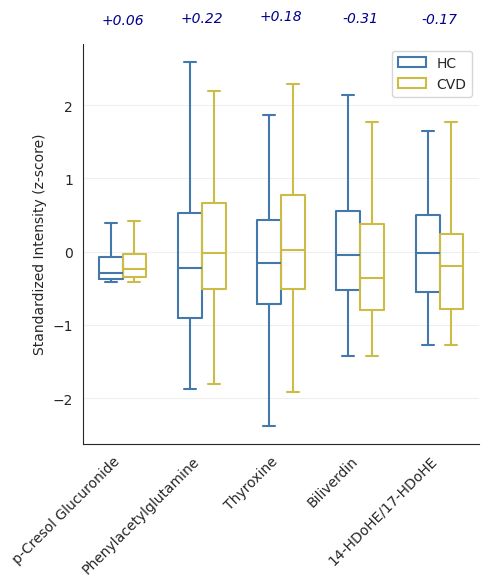

In [720]:
plot_feature_distribution_by_condition(
    matched_df_knn, 
    features=['p-cresol glucuronide*', 'phenylacetylglutamine', 'thyroxine', 'biliverdin', '14-HDoHE/17-HDoHE'], 
    condition_col='is_cardio', 
    figsize=(5, 6), 
    apply_scaling=True,
    show_stats=True,
    show_swarm=False,
    save_path= figs_dir + 'cardio_feature_distribution_3.png',
    _palette=['#4477AA', '#CCBB44'],
    custom_feature_names={
        'p-cresol glucuronide*': 'p-Cresol Glucuronide',
        'phenylacetylglutamine': 'Phenylacetylglutamine',
        'thyroxine': 'Thyroxine',
        'biliverdin': 'Biliverdin',
        '14-HDoHE/17-HDoHE': '14-HDoHE/17-HDoHE'
    }
)

In [590]:
diet_features_updated.columns.to_list()

['Acorn squash',
 'Alfalfa sprouts',
 'Almond Beverage',
 'Almond flour',
 'Almond spread',
 'Almonds',
 'Amba',
 'Apple',
 'Apple Cake',
 'Apple Vinegar',
 'Apple juice',
 'Apricot',
 'Apropo',
 'Artichoke',
 'Arugula',
 'Asparagus',
 'Avocado',
 'Avocado Sandwich',
 'Bagel',
 'Baguette',
 'Baked apple',
 'Baklava',
 'Balsamic vinegar',
 'Bamba',
 'Banana',
 'Banana Cake',
 'Barbecue sauce',
 'Barley soup',
 'Basil',
 'Bean Noodles',
 'Bean soup',
 'Beans',
 'Beans black-eyed peas',
 'Beef',
 'Beef Cholent',
 'Beef Lasagna',
 'Beef Shawarma',
 'Beer',
 'Beet',
 'Beet Salad',
 'Berries',
 'Biscuit',
 'Bissli',
 'Black beans',
 'Blintzes',
 'Blue Cheese',
 'Blueberries',
 'Boiled corn',
 'Bolognese',
 'Bounty',
 'Brazil nuts',
 'Bread',
 'Bread Crumbs',
 'Brioche',
 'Broccoli',
 'Broth',
 'Brown Rice',
 'Brown Sugar',
 'Brownies',
 'Buckwheat Bread',
 'Buckwheat crackers',
 'Bulgur',
 'Burekas',
 'Butter',
 'Butter Cookies',
 'Caesar Salad',
 'Cake',
 'Calamari',
 'Camembert or Brie',
 

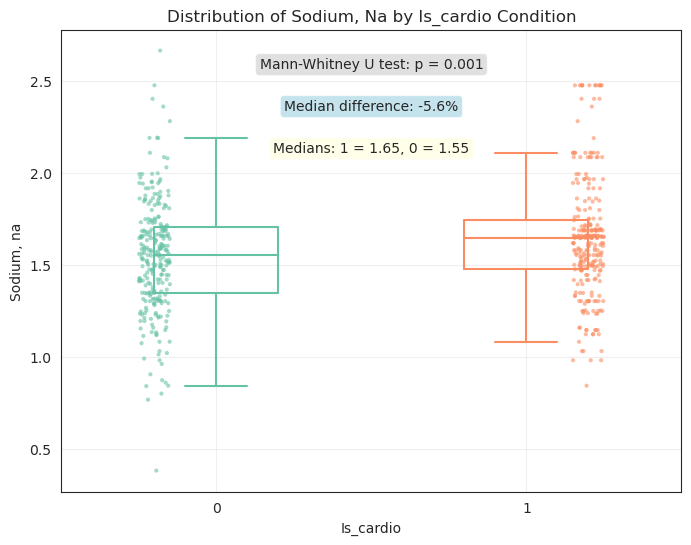

In [656]:
plot_feature_distribution_by_condition(
    matched_df_knn_diet, 
    feature='Sodium, Na', 
    condition_col='is_cardio', 
    figsize=(8, 6),
)